## ML Assignment 4
### Progamming Part

### Implementing MultiLayer Perceptron
### Submitted By:- Ayush Sethi (as11500) , Darshil Patel (ddp337)

In [1]:
import numpy as np
import re
import copy
import pandas as pd

def loadData(fileName, fileType):
    global word_list
    input_file = open(fileName, 'r')
    file_contents = input_file.read()
    decisionClass = copy.deepcopy(file_contents)
    file_contents = copy.deepcopy(re.sub('[01`]', '', file_contents))
    input_file.close()
    if fileType == "train":
        word_list = file_contents.split()
        word_list = set(word_list)
        word_list = dict.fromkeys(word_list, 0)
    desired_list = [(set(x.split())) for x in file_contents.split("\n")]
    decisionClass = [(x[:1]) for x in decisionClass.split("\n")]
    final_dataset = []
    for attributes in desired_list:
        a = copy.deepcopy(word_list)
        for i in attributes:
            if i in a.keys():
                a[i]+=1
        final_dataset.append(np.array(list(a.values())))  
    final_dataset = pd.DataFrame(final_dataset, columns = word_list.keys()) 
    
    return final_dataset, decisionClass

In [2]:
word_list = []
trainingDataset, trainingLabels = loadData('reviewstrain.txt', 'train')
testingDataset, testingLabels = loadData('reviewstest.txt', 'test')

## 5(a) top 5

In [27]:
sumOfAttributes = [sum(trainingDataset[i]) for i in trainingDataset]
listWordList = list(word_list)
temp = [(listWordList[sumOfAttributes.index(i)],i)  for i in sorted(sumOfAttributes, reverse=True)[:5]]
temp  

[('.', 1426), (',', 816), ('the', 780), ('and', 737), ('a', 722)]

## Entropy

In [4]:
import math 
def entropy(n1, listOfLabels):
    n = list(n1)
    ent = 0
    for i in listOfLabels:
        ent += (n.count(i)/len(n))*math.log((n.count(i)/len(n)),2)
    return -ent    

def informationGain(attribute, decisionClass):
    inf_gain = 0
    attributewithclass =  np.column_stack((attribute, decisionClass))
    parentEntropy = entropy(attributewithclass[:, [1]],np.unique(attributewithclass[:, [1]]))
    positiveChild = attributewithclass[attributewithclass[:,0] == '1'][:,np.array([False, True])]
    negativeChild = attributewithclass[attributewithclass[:,0] == '0'][:,np.array([False, True])]
    
    childEntropy = ((len(positiveChild)/(len(positiveChild)+ len(negativeChild)))*(entropy(positiveChild, np.unique(positiveChild)))) + ((len(negativeChild)/(len(positiveChild)+ len(negativeChild)))*(entropy(negativeChild, np.unique(negativeChild))))
    return parentEntropy - childEntropy

In [5]:
result_infogain = []
for i in range(len(word_list)):
    result_infogain.append(informationGain(trainingDataset.iloc[:,i], trainingLabels))  

## 5(B) TOP 5 information Gain

In [25]:
for i in sorted(range(len(result_infogain)), key=lambda i: result_infogain[i], reverse=True)[:5]:
    print(list(word_list)[i],result_infogain[i])

bad 0.02392124422251085
best 0.01952322043864818
n't 0.01344265719912563
too 0.011238484455757591
moving 0.011049245344893266


In [7]:
def selectTopK(k):
    topk = []
    for i in sorted(range(len(result_infogain)), key=lambda i: result_infogain[i], reverse=True)[:k]:
        topk.append(list(word_list)[i])
    topkdataset = trainingDataset[topk].copy()    
    topkdataset_test = testingDataset[topk].copy()
    return topkdataset, topkdataset_test

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
      return 1 / (1 + np.exp(-x))

# I is matrix of input examples
# D is matrix of output examples
# n_hidden is number of nodes in hidden layer
# n_max is number of training epochs
def bp(I,D,n_hidden,eta,n_max):
    np.random.seed(1926)
    
    r_inp, c_inp = I.shape
    n_examples = r_inp
    n_input    = c_inp
    r_out,c_out = D.shape
    n_output   = c_out

    w = np.random.random((n_input, n_hidden))
    wb = np.random.random(n_hidden)
    v = np.random.random((n_hidden, n_output))
    vb = np.random.random(n_output)
    err_curve = np.zeros((n_max,c_out))

    for n in range(n_max):
        sq_err_sum = np.zeros((1,n_output))
    
        for k in range(n_examples):
            x = I[k,:].reshape([1,-1])
            z = sigmoid(x.dot(w)+wb)
            y = sigmoid(z.dot(v)+vb)
#             err = (D[k,:] - y).reshape([1,-1])
            err = ((D[k,:] - y)/(y*(1-y)))
            
            sq_err_sum += 0.5*np.square(err)
            
            Delta_output = err*(1-y)*y 
#             Delta_output = err 
            Delta_v = z.T.dot(Delta_output)
            Delta_vb = np.sum(Delta_output,axis=0)

            Delta_hidden = Delta_output.dot(v.T)*(1-z)*z
            Delta_w = x.T.dot(Delta_hidden)    
            Delta_wb = np.sum(Delta_hidden,axis=0) 
        
            v += eta*Delta_v
            vb += eta*Delta_vb
            w += eta*Delta_w
            wb += eta*Delta_wb

            err_curve[n] = sq_err_sum/n_examples
    
        print('epoch %d: err %f'%(n,np.mean(sq_err_sum)/n_examples))
    
    plt.plot(np.linspace(0,n_max-1,n_max),np.mean(err_curve,axis=1))        
    plt.show()
    return w,wb,v,vb,err_curve     

def train(top50dataset, trainingLabels, hiddenNodes, eta, epoch):
    w,wb,v,vb,err_curve = bp(top50dataset.values, np.array(trainingLabels).reshape([-1,1]).astype('int32'), hiddenNodes, eta,epoch)
    return w, wb, v, vb, err_curve

def test(n_examples,w, wb, v, vb):
    predictions = []
    for k in n_examples:
        z = sigmoid(k.dot(w)+wb)
        y = sigmoid(z.dot(v)+vb)
        if y > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)    
    return predictions   

def confusion_matrix(true, pred):
    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0
    for i,j in zip(true,pred):
        if int(i) == 1 and int(i) == int(j):
            true_positive = true_positive + 1
        if int(i) == 0 and int(i) == int(j):
            true_negative = true_negative + 1
        if int(i) == 1 and int(i) != int(j):
            false_negative = false_negative + 1
        if int(i) == 0 and int(i) != int(j):
            false_positive = false_positive + 1
    
    mat = [[true_positive,false_negative],[false_positive,true_negative]]
    accuracy = (true_positive + true_negative)/(true_positive + false_negative + false_positive + true_negative)
    print(accuracy)
    return mat, accuracy    

def runNN(k, hiddenNodes, eta, epoch, typeofTest):
    topkdataset, topkdataset_test = selectTopK(k)
    w, wb, v, vb, err_curve = train(topkdataset, trainingLabels, hiddenNodes, eta, epoch)
    if typeofTest == "train":
        predictions = test(topkdataset.values,w, wb, v, vb)
        matrix = confusion_matrix(trainingLabels,predictions)
    else:
        predictions = test(topkdataset_test.values,w, wb, v, vb)
        matrix = confusion_matrix(testingLabels,predictions)
    print(matrix)
    return matrix
 


## 5(C) Top 50 for Neural net

epoch 0: err 5.452337
epoch 1: err 8.352286
epoch 2: err 8.064625
epoch 3: err 8.152866
epoch 4: err 8.953954
epoch 5: err 9.866710
epoch 6: err 9.930963
epoch 7: err 10.042754
epoch 8: err 10.696441
epoch 9: err 11.368996
epoch 10: err 11.068413
epoch 11: err 10.804709
epoch 12: err 10.103927
epoch 13: err 11.500263
epoch 14: err 10.642717
epoch 15: err 11.303001
epoch 16: err 11.659534
epoch 17: err 11.953903
epoch 18: err 12.270275
epoch 19: err 12.548115
epoch 20: err 12.765875
epoch 21: err 12.970235
epoch 22: err 13.150656
epoch 23: err 13.398197
epoch 24: err 13.623479
epoch 25: err 13.832388
epoch 26: err 14.030337
epoch 27: err 14.247490
epoch 28: err 14.540817
epoch 29: err 15.034630
epoch 30: err 15.844428
epoch 31: err 16.623372
epoch 32: err 17.236697
epoch 33: err 17.733491
epoch 34: err 17.913918
epoch 35: err 16.845487
epoch 36: err 14.544398
epoch 37: err 12.780599
epoch 38: err 12.344306
epoch 39: err 12.245252
epoch 40: err 12.436908
epoch 41: err 12.822704
epoch 42:

epoch 336: err 23.051421
epoch 337: err 23.064300
epoch 338: err 23.076970
epoch 339: err 23.089433
epoch 340: err 23.101693
epoch 341: err 23.113754
epoch 342: err 23.125624
epoch 343: err 23.137309
epoch 344: err 23.148818
epoch 345: err 23.160159
epoch 346: err 23.171343
epoch 347: err 23.182378
epoch 348: err 23.193276
epoch 349: err 23.204047
epoch 350: err 23.214700
epoch 351: err 23.225247
epoch 352: err 23.235698
epoch 353: err 23.246063
epoch 354: err 23.256351
epoch 355: err 23.266571
epoch 356: err 23.276733
epoch 357: err 23.286844
epoch 358: err 23.296912
epoch 359: err 23.306943
epoch 360: err 23.316944
epoch 361: err 23.326920
epoch 362: err 23.336876
epoch 363: err 23.346816
epoch 364: err 23.356743
epoch 365: err 23.366661
epoch 366: err 23.376570
epoch 367: err 23.386473
epoch 368: err 23.396369
epoch 369: err 23.406259
epoch 370: err 23.416143
epoch 371: err 23.426018
epoch 372: err 23.435884
epoch 373: err 23.445737
epoch 374: err 23.455576
epoch 375: err 23.465397


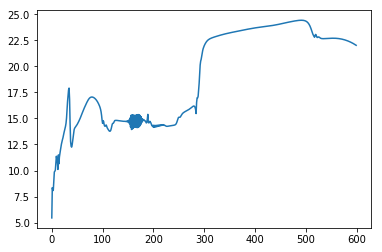

0.732
([[775, 36], [366, 323]], 0.732)
1 1
epoch 0: err 2.159587
epoch 1: err 2.102696
epoch 2: err 2.084165
epoch 3: err 2.217704
epoch 4: err 2.412149
epoch 5: err 2.602019
epoch 6: err 2.767317
epoch 7: err 2.897427
epoch 8: err 2.984240
epoch 9: err 3.035879
epoch 10: err 3.064570
epoch 11: err 3.079724
epoch 12: err 3.087139
epoch 13: err 3.090065
epoch 14: err 3.090303
epoch 15: err 3.088900
epoch 16: err 3.086511
epoch 17: err 3.083571
epoch 18: err 3.080374
epoch 19: err 3.077117
epoch 20: err 3.073924
epoch 21: err 3.070873
epoch 22: err 3.068006
epoch 23: err 3.065341
epoch 24: err 3.062881
epoch 25: err 3.060619
epoch 26: err 3.058546
epoch 27: err 3.056646
epoch 28: err 3.054905
epoch 29: err 3.053308
epoch 30: err 3.051841
epoch 31: err 3.050492
epoch 32: err 3.049248
epoch 33: err 3.048100
epoch 34: err 3.047038
epoch 35: err 3.046052
epoch 36: err 3.045137
epoch 37: err 3.044285
epoch 38: err 3.043491
epoch 39: err 3.042748
epoch 40: err 3.042054
epoch 41: err 3.041402
e

epoch 348: err 3.028104
epoch 349: err 3.028111
epoch 350: err 3.028119
epoch 351: err 3.028126
epoch 352: err 3.028134
epoch 353: err 3.028141
epoch 354: err 3.028148
epoch 355: err 3.028156
epoch 356: err 3.028163
epoch 357: err 3.028171
epoch 358: err 3.028178
epoch 359: err 3.028186
epoch 360: err 3.028193
epoch 361: err 3.028201
epoch 362: err 3.028208
epoch 363: err 3.028216
epoch 364: err 3.028223
epoch 365: err 3.028231
epoch 366: err 3.028238
epoch 367: err 3.028245
epoch 368: err 3.028253
epoch 369: err 3.028260
epoch 370: err 3.028268
epoch 371: err 3.028275
epoch 372: err 3.028283
epoch 373: err 3.028290
epoch 374: err 3.028298
epoch 375: err 3.028305
epoch 376: err 3.028313
epoch 377: err 3.028320
epoch 378: err 3.028328
epoch 379: err 3.028335
epoch 380: err 3.028343
epoch 381: err 3.028350
epoch 382: err 3.028358
epoch 383: err 3.028365
epoch 384: err 3.028373
epoch 385: err 3.028380
epoch 386: err 3.028388
epoch 387: err 3.028395
epoch 388: err 3.028403
epoch 389: err 3

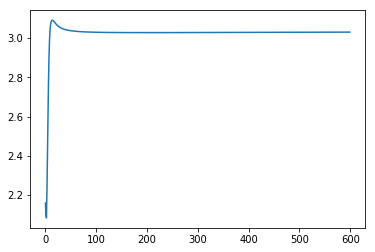

0.7306666666666667
([[704, 107], [297, 392]], 0.7306666666666667)
1 0.1
epoch 0: err 2.057580
epoch 1: err 2.027702
epoch 2: err 2.026046
epoch 3: err 2.024689
epoch 4: err 2.023507
epoch 5: err 2.022427
epoch 6: err 2.021386
epoch 7: err 2.020333
epoch 8: err 2.019216
epoch 9: err 2.017980
epoch 10: err 2.016564
epoch 11: err 2.014889
epoch 12: err 2.012860
epoch 13: err 2.010345
epoch 14: err 2.007174
epoch 15: err 2.003121
epoch 16: err 1.997904
epoch 17: err 1.991222
epoch 18: err 1.982892
epoch 19: err 1.973157
epoch 20: err 1.963110
epoch 21: err 1.954755
epoch 22: err 1.950119
epoch 23: err 1.949967
epoch 24: err 1.953461
epoch 25: err 1.958944
epoch 26: err 1.964830
epoch 27: err 1.970046
epoch 28: err 1.974092
epoch 29: err 1.976936
epoch 30: err 1.978861
epoch 31: err 1.980323
epoch 32: err 1.981817
epoch 33: err 1.983775
epoch 34: err 1.986484
epoch 35: err 1.990062
epoch 36: err 1.994459
epoch 37: err 1.999503
epoch 38: err 2.004951
epoch 39: err 2.010550
epoch 40: err 2.01

epoch 343: err 2.518176
epoch 344: err 2.518206
epoch 345: err 2.518236
epoch 346: err 2.518265
epoch 347: err 2.518294
epoch 348: err 2.518322
epoch 349: err 2.518349
epoch 350: err 2.518376
epoch 351: err 2.518402
epoch 352: err 2.518428
epoch 353: err 2.518453
epoch 354: err 2.518478
epoch 355: err 2.518502
epoch 356: err 2.518525
epoch 357: err 2.518548
epoch 358: err 2.518570
epoch 359: err 2.518592
epoch 360: err 2.518613
epoch 361: err 2.518634
epoch 362: err 2.518654
epoch 363: err 2.518674
epoch 364: err 2.518693
epoch 365: err 2.518712
epoch 366: err 2.518730
epoch 367: err 2.518748
epoch 368: err 2.518765
epoch 369: err 2.518782
epoch 370: err 2.518798
epoch 371: err 2.518814
epoch 372: err 2.518830
epoch 373: err 2.518845
epoch 374: err 2.518859
epoch 375: err 2.518873
epoch 376: err 2.518887
epoch 377: err 2.518900
epoch 378: err 2.518913
epoch 379: err 2.518926
epoch 380: err 2.518938
epoch 381: err 2.518949
epoch 382: err 2.518961
epoch 383: err 2.518971
epoch 384: err 2

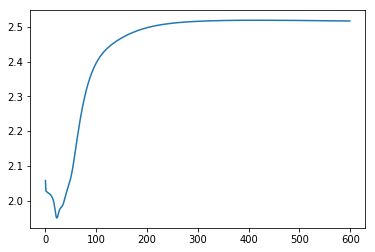

0.7366666666666667
([[678, 133], [262, 427]], 0.7366666666666667)
1 0.01
epoch 0: err 2.134005
epoch 1: err 2.066896
epoch 2: err 2.040655
epoch 3: err 2.029297
epoch 4: err 2.023904
epoch 5: err 2.021132
epoch 6: err 2.019604
epoch 7: err 2.018701
epoch 8: err 2.018124
epoch 9: err 2.017722
epoch 10: err 2.017417
epoch 11: err 2.017165
epoch 12: err 2.016945
epoch 13: err 2.016744
epoch 14: err 2.016555
epoch 15: err 2.016375
epoch 16: err 2.016201
epoch 17: err 2.016032
epoch 18: err 2.015868
epoch 19: err 2.015708
epoch 20: err 2.015551
epoch 21: err 2.015398
epoch 22: err 2.015248
epoch 23: err 2.015101
epoch 24: err 2.014957
epoch 25: err 2.014816
epoch 26: err 2.014678
epoch 27: err 2.014542
epoch 28: err 2.014409
epoch 29: err 2.014278
epoch 30: err 2.014149
epoch 31: err 2.014023
epoch 32: err 2.013899
epoch 33: err 2.013777
epoch 34: err 2.013656
epoch 35: err 2.013538
epoch 36: err 2.013421
epoch 37: err 2.013306
epoch 38: err 2.013193
epoch 39: err 2.013081
epoch 40: err 2.0

epoch 346: err 1.970090
epoch 347: err 1.970262
epoch 348: err 1.970442
epoch 349: err 1.970631
epoch 350: err 1.970827
epoch 351: err 1.971032
epoch 352: err 1.971244
epoch 353: err 1.971465
epoch 354: err 1.971694
epoch 355: err 1.971931
epoch 356: err 1.972176
epoch 357: err 1.972428
epoch 358: err 1.972689
epoch 359: err 1.972957
epoch 360: err 1.973233
epoch 361: err 1.973517
epoch 362: err 1.973808
epoch 363: err 1.974106
epoch 364: err 1.974411
epoch 365: err 1.974723
epoch 366: err 1.975041
epoch 367: err 1.975367
epoch 368: err 1.975698
epoch 369: err 1.976035
epoch 370: err 1.976379
epoch 371: err 1.976728
epoch 372: err 1.977082
epoch 373: err 1.977442
epoch 374: err 1.977806
epoch 375: err 1.978176
epoch 376: err 1.978549
epoch 377: err 1.978927
epoch 378: err 1.979309
epoch 379: err 1.979695
epoch 380: err 1.980084
epoch 381: err 1.980476
epoch 382: err 1.980872
epoch 383: err 1.981270
epoch 384: err 1.981670
epoch 385: err 1.982073
epoch 386: err 1.982477
epoch 387: err 1

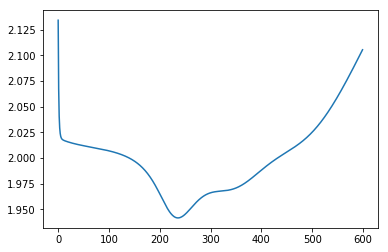

0.734
([[692, 119], [280, 409]], 0.734)
1 0.001
epoch 0: err 2.174472
epoch 1: err 2.160466
epoch 2: err 2.147852
epoch 3: err 2.136477
epoch 4: err 2.126210
epoch 5: err 2.116933
epoch 6: err 2.108542
epoch 7: err 2.100944
epoch 8: err 2.094057
epoch 9: err 2.087808
epoch 10: err 2.082132
epoch 11: err 2.076971
epoch 12: err 2.072274
epoch 13: err 2.067993
epoch 14: err 2.064090
epoch 15: err 2.060525
epoch 16: err 2.057268
epoch 17: err 2.054287
epoch 18: err 2.051558
epoch 19: err 2.049055
epoch 20: err 2.046759
epoch 21: err 2.044650
epoch 22: err 2.042710
epoch 23: err 2.040925
epoch 24: err 2.039281
epoch 25: err 2.037764
epoch 26: err 2.036364
epoch 27: err 2.035071
epoch 28: err 2.033876
epoch 29: err 2.032769
epoch 30: err 2.031744
epoch 31: err 2.030793
epoch 32: err 2.029911
epoch 33: err 2.029092
epoch 34: err 2.028331
epoch 35: err 2.027623
epoch 36: err 2.026964
epoch 37: err 2.026349
epoch 38: err 2.025777
epoch 39: err 2.025242
epoch 40: err 2.024743
epoch 41: err 2.024

epoch 346: err 2.012830
epoch 347: err 2.012819
epoch 348: err 2.012807
epoch 349: err 2.012795
epoch 350: err 2.012783
epoch 351: err 2.012772
epoch 352: err 2.012760
epoch 353: err 2.012748
epoch 354: err 2.012736
epoch 355: err 2.012725
epoch 356: err 2.012713
epoch 357: err 2.012701
epoch 358: err 2.012690
epoch 359: err 2.012678
epoch 360: err 2.012667
epoch 361: err 2.012655
epoch 362: err 2.012643
epoch 363: err 2.012632
epoch 364: err 2.012620
epoch 365: err 2.012609
epoch 366: err 2.012597
epoch 367: err 2.012586
epoch 368: err 2.012575
epoch 369: err 2.012563
epoch 370: err 2.012552
epoch 371: err 2.012540
epoch 372: err 2.012529
epoch 373: err 2.012517
epoch 374: err 2.012506
epoch 375: err 2.012495
epoch 376: err 2.012483
epoch 377: err 2.012472
epoch 378: err 2.012461
epoch 379: err 2.012450
epoch 380: err 2.012438
epoch 381: err 2.012427
epoch 382: err 2.012416
epoch 383: err 2.012405
epoch 384: err 2.012393
epoch 385: err 2.012382
epoch 386: err 2.012371
epoch 387: err 2

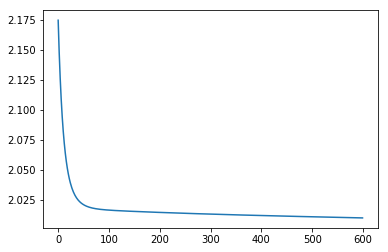

0.5406666666666666
([[811, 0], [689, 0]], 0.5406666666666666)
1 0.0001
epoch 0: err 7.785959
epoch 1: err 14.078871
epoch 2: err 19.876372
epoch 3: err 37.924227
epoch 4: err 68.385416
epoch 5: err 84.045443
epoch 6: err 80.024595
epoch 7: err 66.962222
epoch 8: err 48.208195
epoch 9: err 36.013294
epoch 10: err 31.043546
epoch 11: err 26.233309
epoch 12: err 24.654887
epoch 13: err 23.259519
epoch 14: err 22.381739
epoch 15: err 20.720921
epoch 16: err 21.043621
epoch 17: err 19.200567
epoch 18: err 17.075389
epoch 19: err 22.100019
epoch 20: err 27.571400
epoch 21: err 3973.131795
epoch 22: err 12.280102
epoch 23: err 11.199200
epoch 24: err 14.002528
epoch 25: err 21.985842
epoch 26: err 30.237951
epoch 27: err 41.258389
epoch 28: err 61.743128
epoch 29: err 70.951741
epoch 30: err 71.895407
epoch 31: err 73.223940
epoch 32: err 71.480720
epoch 33: err 66.831492
epoch 34: err 61.886776
epoch 35: err 38.376116
epoch 36: err 27.865339
epoch 37: err 27.033477
epoch 38: err 29.630303
ep

epoch 335: err 8.249965
epoch 336: err 8.248332
epoch 337: err 8.246415
epoch 338: err 8.244147
epoch 339: err 8.241509
epoch 340: err 8.238435
epoch 341: err 8.234910
epoch 342: err 8.230884
epoch 343: err 8.226351
epoch 344: err 8.221306
epoch 345: err 8.215761
epoch 346: err 8.209765
epoch 347: err 8.203350
epoch 348: err 8.196621
epoch 349: err 8.189617
epoch 350: err 8.182466
epoch 351: err 8.175206
epoch 352: err 8.167942
epoch 353: err 8.160715
epoch 354: err 8.153563
epoch 355: err 8.146558
epoch 356: err 8.139636
epoch 357: err 8.132937
epoch 358: err 8.126287
epoch 359: err 8.119900
epoch 360: err 8.113523
epoch 361: err 8.107400
epoch 362: err 8.101288
epoch 363: err 8.095353
epoch 364: err 8.089510
epoch 365: err 8.083673
epoch 366: err 8.078119
epoch 367: err 8.072291
epoch 368: err 8.067056
epoch 369: err 8.061165
epoch 370: err 8.056272
epoch 371: err 8.050280
epoch 372: err 8.045723
epoch 373: err 8.039649
epoch 374: err 8.035360
epoch 375: err 8.029311
epoch 376: err 8

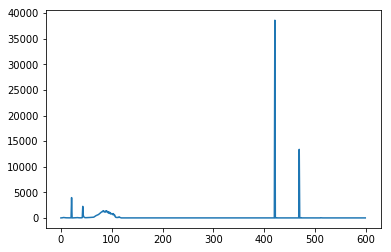

0.7606666666666667
([[716, 95], [264, 425]], 0.7606666666666667)
5 1
epoch 0: err 2.554150
epoch 1: err 2.297027
epoch 2: err 2.510745
epoch 3: err 2.785994
epoch 4: err 2.982265
epoch 5: err 3.079728
epoch 6: err 3.071734
epoch 7: err 3.024028
epoch 8: err 2.984089
epoch 9: err 2.965518
epoch 10: err 2.966884
epoch 11: err 2.981820
epoch 12: err 3.003570
epoch 13: err 3.026998
epoch 14: err 3.048880
epoch 15: err 3.067451
epoch 16: err 3.081871
epoch 17: err 3.091862
epoch 18: err 3.097474
epoch 19: err 3.098941
epoch 20: err 3.096575
epoch 21: err 3.090711
epoch 22: err 3.081687
epoch 23: err 3.069849
epoch 24: err 3.055572
epoch 25: err 3.039266
epoch 26: err 3.021374
epoch 27: err 3.002351
epoch 28: err 2.982636
epoch 29: err 2.962615
epoch 30: err 2.942603
epoch 31: err 2.922830
epoch 32: err 2.903441
epoch 33: err 2.884503
epoch 34: err 2.866028
epoch 35: err 2.847984
epoch 36: err 2.830331
epoch 37: err 2.813048
epoch 38: err 2.796168
epoch 39: err 2.779805
epoch 40: err 2.76415

epoch 347: err 2.898342
epoch 348: err 2.899507
epoch 349: err 2.900688
epoch 350: err 2.901886
epoch 351: err 2.903101
epoch 352: err 2.904333
epoch 353: err 2.905582
epoch 354: err 2.906850
epoch 355: err 2.908135
epoch 356: err 2.909439
epoch 357: err 2.910761
epoch 358: err 2.912102
epoch 359: err 2.913462
epoch 360: err 2.914841
epoch 361: err 2.916239
epoch 362: err 2.917656
epoch 363: err 2.919092
epoch 364: err 2.920548
epoch 365: err 2.922022
epoch 366: err 2.923517
epoch 367: err 2.925031
epoch 368: err 2.926564
epoch 369: err 2.928117
epoch 370: err 2.929689
epoch 371: err 2.931281
epoch 372: err 2.932892
epoch 373: err 2.934523
epoch 374: err 2.936173
epoch 375: err 2.937842
epoch 376: err 2.939530
epoch 377: err 2.941238
epoch 378: err 2.942964
epoch 379: err 2.944710
epoch 380: err 2.946474
epoch 381: err 2.948257
epoch 382: err 2.950059
epoch 383: err 2.951879
epoch 384: err 2.953718
epoch 385: err 2.955575
epoch 386: err 2.957450
epoch 387: err 2.959343
epoch 388: err 2

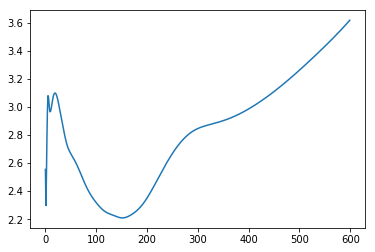

0.7673333333333333
([[744, 67], [282, 407]], 0.7673333333333333)
5 0.1
epoch 0: err 3.772713
epoch 1: err 2.042822
epoch 2: err 2.030880
epoch 3: err 2.019741
epoch 4: err 2.008706
epoch 5: err 1.997606
epoch 6: err 1.986871
epoch 7: err 1.977496
epoch 8: err 1.970728
epoch 9: err 1.967456
epoch 10: err 1.967719
epoch 11: err 1.970678
epoch 12: err 1.975014
epoch 13: err 1.979419
epoch 14: err 1.982948
epoch 15: err 1.985179
epoch 16: err 1.986204
epoch 17: err 1.986491
epoch 18: err 1.986697
epoch 19: err 1.987448
epoch 20: err 1.989188
epoch 21: err 1.992105
epoch 22: err 1.996141
epoch 23: err 2.001072
epoch 24: err 2.006601
epoch 25: err 2.012453
epoch 26: err 2.018435
epoch 27: err 2.024462
epoch 28: err 2.030558
epoch 29: err 2.036828
epoch 30: err 2.043427
epoch 31: err 2.050525
epoch 32: err 2.058277
epoch 33: err 2.066801
epoch 34: err 2.076171
epoch 35: err 2.086412
epoch 36: err 2.097502
epoch 37: err 2.109380
epoch 38: err 2.121957
epoch 39: err 2.135124
epoch 40: err 2.148

epoch 343: err 2.504360
epoch 344: err 2.505597
epoch 345: err 2.506851
epoch 346: err 2.508123
epoch 347: err 2.509414
epoch 348: err 2.510724
epoch 349: err 2.512054
epoch 350: err 2.513403
epoch 351: err 2.514772
epoch 352: err 2.516161
epoch 353: err 2.517570
epoch 354: err 2.519001
epoch 355: err 2.520453
epoch 356: err 2.521926
epoch 357: err 2.523420
epoch 358: err 2.524937
epoch 359: err 2.526475
epoch 360: err 2.528036
epoch 361: err 2.529619
epoch 362: err 2.531224
epoch 363: err 2.532852
epoch 364: err 2.534503
epoch 365: err 2.536177
epoch 366: err 2.537874
epoch 367: err 2.539594
epoch 368: err 2.541337
epoch 369: err 2.543104
epoch 370: err 2.544894
epoch 371: err 2.546706
epoch 372: err 2.548542
epoch 373: err 2.550402
epoch 374: err 2.552284
epoch 375: err 2.554190
epoch 376: err 2.556119
epoch 377: err 2.558071
epoch 378: err 2.560045
epoch 379: err 2.562043
epoch 380: err 2.564063
epoch 381: err 2.566106
epoch 382: err 2.568171
epoch 383: err 2.570258
epoch 384: err 2

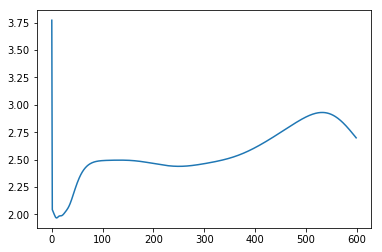

0.762
([[705, 106], [251, 438]], 0.762)
5 0.01
epoch 0: err 17.154174
epoch 1: err 2.550898
epoch 2: err 2.077718
epoch 3: err 2.035228
epoch 4: err 2.027680
epoch 5: err 2.024993
epoch 6: err 2.023292
epoch 7: err 2.021841
epoch 8: err 2.020472
epoch 9: err 2.019145
epoch 10: err 2.017849
epoch 11: err 2.016579
epoch 12: err 2.015334
epoch 13: err 2.014111
epoch 14: err 2.012910
epoch 15: err 2.011727
epoch 16: err 2.010563
epoch 17: err 2.009415
epoch 18: err 2.008282
epoch 19: err 2.007162
epoch 20: err 2.006056
epoch 21: err 2.004960
epoch 22: err 2.003875
epoch 23: err 2.002800
epoch 24: err 2.001732
epoch 25: err 2.000672
epoch 26: err 1.999619
epoch 27: err 1.998571
epoch 28: err 1.997528
epoch 29: err 1.996489
epoch 30: err 1.995454
epoch 31: err 1.994421
epoch 32: err 1.993390
epoch 33: err 1.992361
epoch 34: err 1.991333
epoch 35: err 1.990306
epoch 36: err 1.989278
epoch 37: err 1.988251
epoch 38: err 1.987223
epoch 39: err 1.986194
epoch 40: err 1.985164
epoch 41: err 1.984

epoch 344: err 2.024746
epoch 345: err 2.025747
epoch 346: err 2.026756
epoch 347: err 2.027774
epoch 348: err 2.028802
epoch 349: err 2.029838
epoch 350: err 2.030883
epoch 351: err 2.031937
epoch 352: err 2.033000
epoch 353: err 2.034071
epoch 354: err 2.035151
epoch 355: err 2.036240
epoch 356: err 2.037337
epoch 357: err 2.038443
epoch 358: err 2.039557
epoch 359: err 2.040679
epoch 360: err 2.041810
epoch 361: err 2.042948
epoch 362: err 2.044095
epoch 363: err 2.045249
epoch 364: err 2.046412
epoch 365: err 2.047582
epoch 366: err 2.048760
epoch 367: err 2.049945
epoch 368: err 2.051138
epoch 369: err 2.052339
epoch 370: err 2.053546
epoch 371: err 2.054761
epoch 372: err 2.055982
epoch 373: err 2.057211
epoch 374: err 2.058447
epoch 375: err 2.059689
epoch 376: err 2.060938
epoch 377: err 2.062193
epoch 378: err 2.063455
epoch 379: err 2.064722
epoch 380: err 2.065996
epoch 381: err 2.067276
epoch 382: err 2.068562
epoch 383: err 2.069854
epoch 384: err 2.071151
epoch 385: err 2

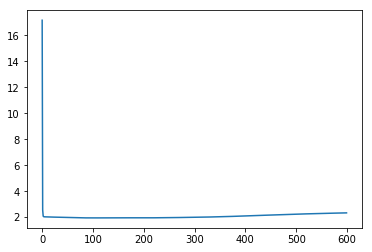

0.736
([[698, 113], [283, 406]], 0.736)
5 0.001
epoch 0: err 55.205434
epoch 1: err 35.499526
epoch 2: err 23.590646
epoch 3: err 16.245912
epoch 4: err 11.617554
epoch 5: err 8.635550
epoch 6: err 6.671151
epoch 7: err 5.348889
epoch 8: err 4.440552
epoch 9: err 3.804780
epoch 10: err 3.352238
epoch 11: err 3.025303
epoch 12: err 2.786028
epoch 13: err 2.608923
epoch 14: err 2.476540
epoch 15: err 2.376725
epoch 16: err 2.300880
epoch 17: err 2.242839
epoch 18: err 2.198128
epoch 19: err 2.163469
epoch 20: err 2.136437
epoch 21: err 2.115225
epoch 22: err 2.098479
epoch 23: err 2.085180
epoch 24: err 2.074552
epoch 25: err 2.066007
epoch 26: err 2.059094
epoch 27: err 2.053465
epoch 28: err 2.048854
epoch 29: err 2.045053
epoch 30: err 2.041900
epoch 31: err 2.039268
epoch 32: err 2.037058
epoch 33: err 2.035191
epoch 34: err 2.033605
epoch 35: err 2.032249
epoch 36: err 2.031082
epoch 37: err 2.030074
epoch 38: err 2.029197
epoch 39: err 2.028429
epoch 40: err 2.027754
epoch 41: err 

epoch 346: err 1.989296
epoch 347: err 1.989194
epoch 348: err 1.989092
epoch 349: err 1.988990
epoch 350: err 1.988888
epoch 351: err 1.988787
epoch 352: err 1.988685
epoch 353: err 1.988583
epoch 354: err 1.988481
epoch 355: err 1.988379
epoch 356: err 1.988278
epoch 357: err 1.988176
epoch 358: err 1.988074
epoch 359: err 1.987972
epoch 360: err 1.987870
epoch 361: err 1.987769
epoch 362: err 1.987667
epoch 363: err 1.987565
epoch 364: err 1.987463
epoch 365: err 1.987362
epoch 366: err 1.987260
epoch 367: err 1.987158
epoch 368: err 1.987056
epoch 369: err 1.986954
epoch 370: err 1.986853
epoch 371: err 1.986751
epoch 372: err 1.986649
epoch 373: err 1.986547
epoch 374: err 1.986445
epoch 375: err 1.986343
epoch 376: err 1.986242
epoch 377: err 1.986140
epoch 378: err 1.986038
epoch 379: err 1.985936
epoch 380: err 1.985834
epoch 381: err 1.985732
epoch 382: err 1.985630
epoch 383: err 1.985529
epoch 384: err 1.985427
epoch 385: err 1.985325
epoch 386: err 1.985223
epoch 387: err 1

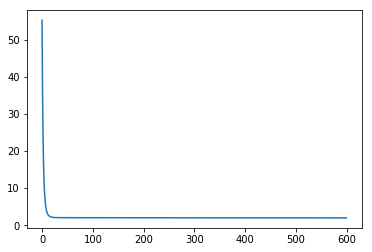

0.6006666666666667
([[730, 81], [518, 171]], 0.6006666666666667)
5 0.0001
epoch 0: err 17.432993
epoch 1: err 10.928387
epoch 2: err 15.966057
epoch 3: err 13.508968
epoch 4: err 32.936802
epoch 5: err 59.849654
epoch 6: err 46.940439
epoch 7: err 36.294551
epoch 8: err 29.053819
epoch 9: err 28.924169
epoch 10: err 34.149139
epoch 11: err 44.517205
epoch 12: err 47.037109
epoch 13: err 44.233634
epoch 14: err 47.424728
epoch 15: err 56.910950
epoch 16: err 113.739338
epoch 17: err 149.190982
epoch 18: err 241.363937
epoch 19: err 370.299918
epoch 20: err 868.710057
epoch 21: err 960.222130
epoch 22: err 639.713289
epoch 23: err 554.075030
epoch 24: err 379.260559
epoch 25: err 398.915619
epoch 26: err 143.352120
epoch 27: err 62.909768
epoch 28: err 19.637388
epoch 29: err 9.891098
epoch 30: err 6.760472
epoch 31: err 6.619468
epoch 32: err 5.368829
epoch 33: err 6.547267
epoch 34: err 8.387036
epoch 35: err 7.365768
epoch 36: err 9.856870
epoch 37: err 7.294576
epoch 38: err 10.74091

epoch 341: err 5.320364
epoch 342: err 5.285388
epoch 343: err 5.379337
epoch 344: err 6.397784
epoch 345: err 5.376262
epoch 346: err 5.408431
epoch 347: err 5.299058
epoch 348: err 5.361081
epoch 349: err 6.390558
epoch 350: err 5.379379
epoch 351: err 5.389490
epoch 352: err 6.161508
epoch 353: err 5.451921
epoch 354: err 5.365374
epoch 355: err 6.799658
epoch 356: err 5.869884
epoch 357: err 5.354337
epoch 358: err 5.681513
epoch 359: err 5.781296
epoch 360: err 7.632830
epoch 361: err 5.479045
epoch 362: err 5.397904
epoch 363: err 5.321116
epoch 364: err 5.861981
epoch 365: err 9.627762
epoch 366: err 6.661499
epoch 367: err 5.467729
epoch 368: err 5.490860
epoch 369: err 5.394384
epoch 370: err 5.360850
epoch 371: err 5.434758
epoch 372: err 6.488679
epoch 373: err 5.391346
epoch 374: err 5.478730
epoch 375: err 5.388100
epoch 376: err 6.553472
epoch 377: err 5.681507
epoch 378: err 5.497081
epoch 379: err 5.366917
epoch 380: err 5.395217
epoch 381: err 5.365250
epoch 382: err 6

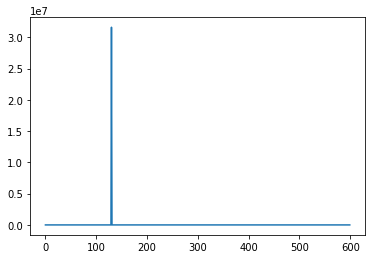

0.7606666666666667
([[793, 18], [341, 348]], 0.7606666666666667)
10 1
epoch 0: err 3.764302
epoch 1: err 2.778199
epoch 2: err 3.005025
epoch 3: err 3.294519
epoch 4: err 3.507972
epoch 5: err 3.569224
epoch 6: err 3.511431
epoch 7: err 3.419429
epoch 8: err 3.322822
epoch 9: err 3.228838
epoch 10: err 3.147294
epoch 11: err 3.087704
epoch 12: err 3.052927
epoch 13: err 3.039320
epoch 14: err 3.040389
epoch 15: err 3.049920
epoch 16: err 3.063324
epoch 17: err 3.077762
epoch 18: err 3.091783
epoch 19: err 3.104858
epoch 20: err 3.116959
epoch 21: err 3.128248
epoch 22: err 3.138866
epoch 23: err 3.148834
epoch 24: err 3.158029
epoch 25: err 3.166194
epoch 26: err 3.172984
epoch 27: err 3.177996
epoch 28: err 3.180809
epoch 29: err 3.181005
epoch 30: err 3.178182
epoch 31: err 3.171966
epoch 32: err 3.162021
epoch 33: err 3.148069
epoch 34: err 3.129920
epoch 35: err 3.107521
epoch 36: err 3.080994
epoch 37: err 3.050657
epoch 38: err 3.017003
epoch 39: err 2.980646
epoch 40: err 2.9422

epoch 347: err 1.978083
epoch 348: err 1.977523
epoch 349: err 1.976961
epoch 350: err 1.976398
epoch 351: err 1.975834
epoch 352: err 1.975268
epoch 353: err 1.974701
epoch 354: err 1.974133
epoch 355: err 1.973564
epoch 356: err 1.972993
epoch 357: err 1.972422
epoch 358: err 1.971849
epoch 359: err 1.971276
epoch 360: err 1.970703
epoch 361: err 1.970129
epoch 362: err 1.969555
epoch 363: err 1.968980
epoch 364: err 1.968406
epoch 365: err 1.967831
epoch 366: err 1.967258
epoch 367: err 1.966684
epoch 368: err 1.966112
epoch 369: err 1.965540
epoch 370: err 1.964969
epoch 371: err 1.964400
epoch 372: err 1.963832
epoch 373: err 1.963266
epoch 374: err 1.962702
epoch 375: err 1.962141
epoch 376: err 1.961582
epoch 377: err 1.961025
epoch 378: err 1.960472
epoch 379: err 1.959921
epoch 380: err 1.959374
epoch 381: err 1.958831
epoch 382: err 1.958292
epoch 383: err 1.957757
epoch 384: err 1.957226
epoch 385: err 1.956700
epoch 386: err 1.956179
epoch 387: err 1.955663
epoch 388: err 1

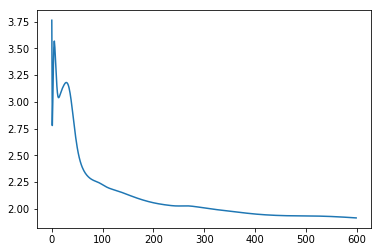

0.7773333333333333
([[730, 81], [253, 436]], 0.7773333333333333)
10 0.1
epoch 0: err 8.867054
epoch 1: err 2.061632
epoch 2: err 2.048384
epoch 3: err 2.035950
epoch 4: err 2.024466
epoch 5: err 2.014787
epoch 6: err 2.008342
epoch 7: err 2.006635
epoch 8: err 2.010492
epoch 9: err 2.019508
epoch 10: err 2.032120
epoch 11: err 2.046185
epoch 12: err 2.059667
epoch 13: err 2.071084
epoch 14: err 2.079666
epoch 15: err 2.085301
epoch 16: err 2.088375
epoch 17: err 2.089582
epoch 18: err 2.089735
epoch 19: err 2.089582
epoch 20: err 2.089680
epoch 21: err 2.090334
epoch 22: err 2.091609
epoch 23: err 2.093409
epoch 24: err 2.095574
epoch 25: err 2.097984
epoch 26: err 2.100619
epoch 27: err 2.103579
epoch 28: err 2.107073
epoch 29: err 2.111370
epoch 30: err 2.116749
epoch 31: err 2.123455
epoch 32: err 2.131661
epoch 33: err 2.141455
epoch 34: err 2.152833
epoch 35: err 2.165711
epoch 36: err 2.179939
epoch 37: err 2.195321
epoch 38: err 2.211633
epoch 39: err 2.228639
epoch 40: err 2.24

epoch 343: err 2.715283
epoch 344: err 2.716292
epoch 345: err 2.717276
epoch 346: err 2.718235
epoch 347: err 2.719168
epoch 348: err 2.720074
epoch 349: err 2.720954
epoch 350: err 2.721806
epoch 351: err 2.722631
epoch 352: err 2.723428
epoch 353: err 2.724196
epoch 354: err 2.724935
epoch 355: err 2.725646
epoch 356: err 2.726326
epoch 357: err 2.726977
epoch 358: err 2.727598
epoch 359: err 2.728188
epoch 360: err 2.728748
epoch 361: err 2.729276
epoch 362: err 2.729774
epoch 363: err 2.730240
epoch 364: err 2.730675
epoch 365: err 2.731078
epoch 366: err 2.731450
epoch 367: err 2.731789
epoch 368: err 2.732096
epoch 369: err 2.732371
epoch 370: err 2.732614
epoch 371: err 2.732825
epoch 372: err 2.733003
epoch 373: err 2.733149
epoch 374: err 2.733262
epoch 375: err 2.733343
epoch 376: err 2.733391
epoch 377: err 2.733407
epoch 378: err 2.733390
epoch 379: err 2.733342
epoch 380: err 2.733261
epoch 381: err 2.733148
epoch 382: err 2.733002
epoch 383: err 2.732825
epoch 384: err 2

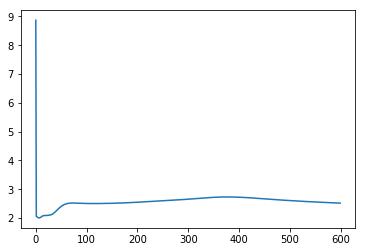

0.7633333333333333
([[698, 113], [242, 447]], 0.7633333333333333)
10 0.01
epoch 0: err 58.063543
epoch 1: err 2.114958
epoch 2: err 2.022190
epoch 3: err 2.018353
epoch 4: err 2.016791
epoch 5: err 2.015387
epoch 6: err 2.014015
epoch 7: err 2.012666
epoch 8: err 2.011336
epoch 9: err 2.010024
epoch 10: err 2.008730
epoch 11: err 2.007452
epoch 12: err 2.006189
epoch 13: err 2.004940
epoch 14: err 2.003704
epoch 15: err 2.002481
epoch 16: err 2.001269
epoch 17: err 2.000068
epoch 18: err 1.998877
epoch 19: err 1.997695
epoch 20: err 1.996522
epoch 21: err 1.995357
epoch 22: err 1.994201
epoch 23: err 1.993051
epoch 24: err 1.991910
epoch 25: err 1.990775
epoch 26: err 1.989646
epoch 27: err 1.988525
epoch 28: err 1.987410
epoch 29: err 1.986301
epoch 30: err 1.985199
epoch 31: err 1.984103
epoch 32: err 1.983015
epoch 33: err 1.981933
epoch 34: err 1.980859
epoch 35: err 1.979793
epoch 36: err 1.978734
epoch 37: err 1.977685
epoch 38: err 1.976644
epoch 39: err 1.975613
epoch 40: err 1

epoch 346: err 2.108095
epoch 347: err 2.109503
epoch 348: err 2.110923
epoch 349: err 2.112356
epoch 350: err 2.113801
epoch 351: err 2.115258
epoch 352: err 2.116728
epoch 353: err 2.118209
epoch 354: err 2.119702
epoch 355: err 2.121207
epoch 356: err 2.122722
epoch 357: err 2.124249
epoch 358: err 2.125787
epoch 359: err 2.127336
epoch 360: err 2.128895
epoch 361: err 2.130464
epoch 362: err 2.132044
epoch 363: err 2.133633
epoch 364: err 2.135232
epoch 365: err 2.136841
epoch 366: err 2.138459
epoch 367: err 2.140085
epoch 368: err 2.141721
epoch 369: err 2.143365
epoch 370: err 2.145018
epoch 371: err 2.146679
epoch 372: err 2.148347
epoch 373: err 2.150024
epoch 374: err 2.151707
epoch 375: err 2.153398
epoch 376: err 2.155096
epoch 377: err 2.156801
epoch 378: err 2.158512
epoch 379: err 2.160230
epoch 380: err 2.161954
epoch 381: err 2.163683
epoch 382: err 2.165418
epoch 383: err 2.167159
epoch 384: err 2.168905
epoch 385: err 2.170655
epoch 386: err 2.172410
epoch 387: err 2

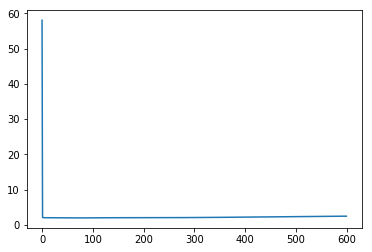

0.7353333333333333
([[695, 116], [281, 408]], 0.7353333333333333)
10 0.001
epoch 0: err 340.385622
epoch 1: err 130.860144
epoch 2: err 54.135057
epoch 3: err 24.648046
epoch 4: err 12.612574
epoch 5: err 7.347139
epoch 6: err 4.870286
epoch 7: err 3.622992
epoch 8: err 2.957225
epoch 9: err 2.584962
epoch 10: err 2.369168
epoch 11: err 2.240454
epoch 12: err 2.161824
epoch 13: err 2.112743
epoch 14: err 2.081467
epoch 15: err 2.061124
epoch 16: err 2.047617
epoch 17: err 2.038462
epoch 18: err 2.032129
epoch 19: err 2.027661
epoch 20: err 2.024450
epoch 21: err 2.022101
epoch 22: err 2.020353
epoch 23: err 2.019030
epoch 24: err 2.018014
epoch 25: err 2.017220
epoch 26: err 2.016589
epoch 27: err 2.016079
epoch 28: err 2.015659
epoch 29: err 2.015307
epoch 30: err 2.015006
epoch 31: err 2.014743
epoch 32: err 2.014509
epoch 33: err 2.014298
epoch 34: err 2.014104
epoch 35: err 2.013922
epoch 36: err 2.013750
epoch 37: err 2.013586
epoch 38: err 2.013428
epoch 39: err 2.013275
epoch 40

epoch 345: err 1.977070
epoch 346: err 1.976964
epoch 347: err 1.976859
epoch 348: err 1.976754
epoch 349: err 1.976650
epoch 350: err 1.976545
epoch 351: err 1.976440
epoch 352: err 1.976335
epoch 353: err 1.976231
epoch 354: err 1.976126
epoch 355: err 1.976022
epoch 356: err 1.975917
epoch 357: err 1.975813
epoch 358: err 1.975709
epoch 359: err 1.975605
epoch 360: err 1.975501
epoch 361: err 1.975397
epoch 362: err 1.975293
epoch 363: err 1.975189
epoch 364: err 1.975085
epoch 365: err 1.974982
epoch 366: err 1.974878
epoch 367: err 1.974775
epoch 368: err 1.974672
epoch 369: err 1.974568
epoch 370: err 1.974465
epoch 371: err 1.974362
epoch 372: err 1.974259
epoch 373: err 1.974156
epoch 374: err 1.974053
epoch 375: err 1.973950
epoch 376: err 1.973848
epoch 377: err 1.973745
epoch 378: err 1.973643
epoch 379: err 1.973540
epoch 380: err 1.973438
epoch 381: err 1.973336
epoch 382: err 1.973234
epoch 383: err 1.973132
epoch 384: err 1.973030
epoch 385: err 1.972928
epoch 386: err 1

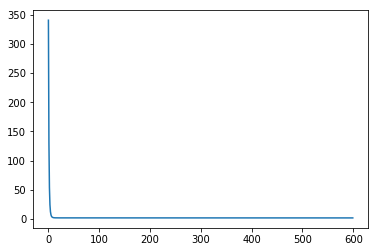

0.614
([[669, 142], [437, 252]], 0.614)
10 0.0001
epoch 0: err 5433.671532
epoch 1: err 11.152923
epoch 2: err 13.892265
epoch 3: err 13.540966
epoch 4: err 12.744210
epoch 5: err 9.993552
epoch 6: err 10.009080
epoch 7: err 11.027493
epoch 8: err 12.178212
epoch 9: err 14.278039
epoch 10: err 12.351906
epoch 11: err 13.938337
epoch 12: err 14.869240
epoch 13: err 12.716215
epoch 14: err 10.744753
epoch 15: err 9.651572
epoch 16: err 8.903533
epoch 17: err 8.358537
epoch 18: err 8.104842
epoch 19: err 8.119628
epoch 20: err 7.363670
epoch 21: err 6.623261
epoch 22: err 6.331453
epoch 23: err 5.718965
epoch 24: err 5.391545
epoch 25: err 5.277052
epoch 26: err 5.993742
epoch 27: err 7.635004
epoch 28: err 8.871876
epoch 29: err 9.137137
epoch 30: err 8.348508
epoch 31: err 9.134449
epoch 32: err 11.324697
epoch 33: err 12.366930
epoch 34: err 12.875868
epoch 35: err 12.222560
epoch 36: err 9.127769
epoch 37: err 7.201015
epoch 38: err 7.957076
epoch 39: err 10.000007
epoch 40: err 20.09

epoch 343: err 4.192616
epoch 344: err 3.788309
epoch 345: err 4.190705
epoch 346: err 3.786371
epoch 347: err 4.188845
epoch 348: err 3.784351
epoch 349: err 4.187170
epoch 350: err 3.782437
epoch 351: err 4.185822
epoch 352: err 3.780781
epoch 353: err 4.184939
epoch 354: err 3.779513
epoch 355: err 4.184641
epoch 356: err 3.778752
epoch 357: err 4.185020
epoch 358: err 3.778627
epoch 359: err 4.186089
epoch 360: err 3.779188
epoch 361: err 4.187587
epoch 362: err 3.780087
epoch 363: err 4.188619
epoch 364: err 3.780107
epoch 365: err 4.187592
epoch 366: err 3.777504
epoch 367: err 4.183086
epoch 368: err 3.771643
epoch 369: err 4.174870
epoch 370: err 3.763696
epoch 371: err 4.163957
epoch 372: err 3.755158
epoch 373: err 4.152085
epoch 374: err 3.746560
epoch 375: err 4.140984
epoch 376: err 3.737571
epoch 377: err 4.131619
epoch 378: err 3.727306
epoch 379: err 4.123904
epoch 380: err 3.714409
epoch 381: err 4.117425
epoch 382: err 3.696607
epoch 383: err 4.112961
epoch 384: err 3

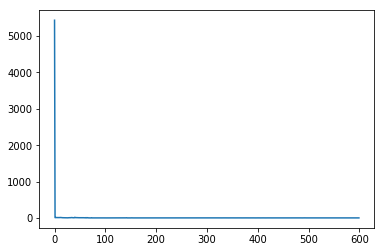

0.7646666666666667
([[795, 16], [337, 352]], 0.7646666666666667)
15 1
epoch 0: err 4151.849309
epoch 1: err 3.018944
epoch 2: err 3.482749
epoch 3: err 3.748464
epoch 4: err 3.780975
epoch 5: err 3.682640
epoch 6: err 3.535706
epoch 7: err 3.404458
epoch 8: err 3.307900
epoch 9: err 3.244218
epoch 10: err 3.206788
epoch 11: err 3.189240
epoch 12: err 3.186423
epoch 13: err 3.194251
epoch 14: err 3.209379
epoch 15: err 3.228997
epoch 16: err 3.250779
epoch 17: err 3.272898
epoch 18: err 3.294039
epoch 19: err 3.313346
epoch 20: err 3.330294
epoch 21: err 3.344562
epoch 22: err 3.355918
epoch 23: err 3.364180
epoch 24: err 3.369222
epoch 25: err 3.371001
epoch 26: err 3.369577
epoch 27: err 3.365120
epoch 28: err 3.357890
epoch 29: err 3.348219
epoch 30: err 3.336479
epoch 31: err 3.323049
epoch 32: err 3.308288
epoch 33: err 3.292508
epoch 34: err 3.275971
epoch 35: err 3.258886
epoch 36: err 3.241422
epoch 37: err 3.223721
epoch 38: err 3.205900
epoch 39: err 3.188057
epoch 40: err 3.1

epoch 344: err 1.941022
epoch 345: err 1.940519
epoch 346: err 1.940020
epoch 347: err 1.939525
epoch 348: err 1.939035
epoch 349: err 1.938548
epoch 350: err 1.938064
epoch 351: err 1.937585
epoch 352: err 1.937109
epoch 353: err 1.936636
epoch 354: err 1.936166
epoch 355: err 1.935699
epoch 356: err 1.935236
epoch 357: err 1.934775
epoch 358: err 1.934318
epoch 359: err 1.933863
epoch 360: err 1.933411
epoch 361: err 1.932961
epoch 362: err 1.932514
epoch 363: err 1.932070
epoch 364: err 1.931628
epoch 365: err 1.931189
epoch 366: err 1.930752
epoch 367: err 1.930317
epoch 368: err 1.929884
epoch 369: err 1.929454
epoch 370: err 1.929026
epoch 371: err 1.928599
epoch 372: err 1.928175
epoch 373: err 1.927754
epoch 374: err 1.927334
epoch 375: err 1.926916
epoch 376: err 1.926500
epoch 377: err 1.926086
epoch 378: err 1.925674
epoch 379: err 1.925263
epoch 380: err 1.924855
epoch 381: err 1.924448
epoch 382: err 1.924043
epoch 383: err 1.923640
epoch 384: err 1.923239
epoch 385: err 1

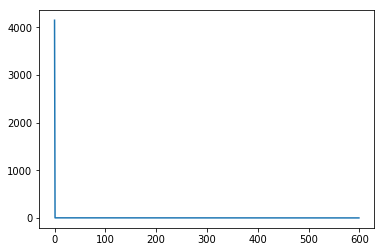

0.7773333333333333
([[725, 86], [248, 441]], 0.7773333333333333)
15 0.1
epoch 0: err 64890.307175
epoch 1: err 2.070589
epoch 2: err 2.052597
epoch 3: err 2.035868
epoch 4: err 2.020654
epoch 5: err 2.008226
epoch 6: err 2.000345
epoch 7: err 1.998318
epoch 8: err 2.002055
epoch 9: err 2.009902
epoch 10: err 2.019419
epoch 11: err 2.028488
epoch 12: err 2.035991
epoch 13: err 2.041867
epoch 14: err 2.046737
epoch 15: err 2.051435
epoch 16: err 2.056629
epoch 17: err 2.062637
epoch 18: err 2.069428
epoch 19: err 2.076744
epoch 20: err 2.084256
epoch 21: err 2.091698
epoch 22: err 2.098952
epoch 23: err 2.106057
epoch 24: err 2.113187
epoch 25: err 2.120597
epoch 26: err 2.128570
epoch 27: err 2.137369
epoch 28: err 2.147205
epoch 29: err 2.158224
epoch 30: err 2.170497
epoch 31: err 2.184027
epoch 32: err 2.198757
epoch 33: err 2.214582
epoch 34: err 2.231362
epoch 35: err 2.248931
epoch 36: err 2.267111
epoch 37: err 2.285718
epoch 38: err 2.304569
epoch 39: err 2.323490
epoch 40: err 

epoch 345: err 3.514981
epoch 346: err 3.513862
epoch 347: err 3.512550
epoch 348: err 3.511043
epoch 349: err 3.509338
epoch 350: err 3.507434
epoch 351: err 3.505327
epoch 352: err 3.503018
epoch 353: err 3.500503
epoch 354: err 3.497781
epoch 355: err 3.494851
epoch 356: err 3.491711
epoch 357: err 3.488359
epoch 358: err 3.484795
epoch 359: err 3.481017
epoch 360: err 3.477025
epoch 361: err 3.472817
epoch 362: err 3.468393
epoch 363: err 3.463753
epoch 364: err 3.458895
epoch 365: err 3.453820
epoch 366: err 3.448527
epoch 367: err 3.443017
epoch 368: err 3.437290
epoch 369: err 3.431346
epoch 370: err 3.425186
epoch 371: err 3.418810
epoch 372: err 3.412220
epoch 373: err 3.405416
epoch 374: err 3.398401
epoch 375: err 3.391175
epoch 376: err 3.383741
epoch 377: err 3.376100
epoch 378: err 3.368254
epoch 379: err 3.360206
epoch 380: err 3.351958
epoch 381: err 3.343513
epoch 382: err 3.334873
epoch 383: err 3.326043
epoch 384: err 3.317026
epoch 385: err 3.307824
epoch 386: err 3

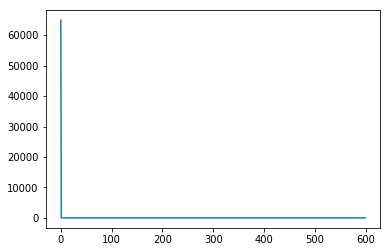

0.7673333333333333
([[713, 98], [251, 438]], 0.7673333333333333)
15 0.01
epoch 0: err 389194.813336
epoch 1: err 2.857575
epoch 2: err 2.017838
epoch 3: err 2.013089
epoch 4: err 2.011119
epoch 5: err 2.009252
epoch 6: err 2.007422
epoch 7: err 2.005626
epoch 8: err 2.003861
epoch 9: err 2.002124
epoch 10: err 2.000413
epoch 11: err 1.998726
epoch 12: err 1.997062
epoch 13: err 1.995418
epoch 14: err 1.993793
epoch 15: err 1.992186
epoch 16: err 1.990595
epoch 17: err 1.989020
epoch 18: err 1.987458
epoch 19: err 1.985909
epoch 20: err 1.984372
epoch 21: err 1.982847
epoch 22: err 1.981333
epoch 23: err 1.979828
epoch 24: err 1.978334
epoch 25: err 1.976849
epoch 26: err 1.975374
epoch 27: err 1.973907
epoch 28: err 1.972450
epoch 29: err 1.971002
epoch 30: err 1.969564
epoch 31: err 1.968135
epoch 32: err 1.966717
epoch 33: err 1.965309
epoch 34: err 1.963913
epoch 35: err 1.962528
epoch 36: err 1.961156
epoch 37: err 1.959798
epoch 38: err 1.958454
epoch 39: err 1.957126
epoch 40: er

epoch 346: err 2.173215
epoch 347: err 2.175126
epoch 348: err 2.177043
epoch 349: err 2.178964
epoch 350: err 2.180889
epoch 351: err 2.182819
epoch 352: err 2.184753
epoch 353: err 2.186691
epoch 354: err 2.188633
epoch 355: err 2.190578
epoch 356: err 2.192527
epoch 357: err 2.194480
epoch 358: err 2.196435
epoch 359: err 2.198394
epoch 360: err 2.200355
epoch 361: err 2.202318
epoch 362: err 2.204284
epoch 363: err 2.206253
epoch 364: err 2.208223
epoch 365: err 2.210195
epoch 366: err 2.212169
epoch 367: err 2.214145
epoch 368: err 2.216122
epoch 369: err 2.218100
epoch 370: err 2.220079
epoch 371: err 2.222059
epoch 372: err 2.224040
epoch 373: err 2.226021
epoch 374: err 2.228002
epoch 375: err 2.229984
epoch 376: err 2.231966
epoch 377: err 2.233947
epoch 378: err 2.235929
epoch 379: err 2.237910
epoch 380: err 2.239890
epoch 381: err 2.241870
epoch 382: err 2.243848
epoch 383: err 2.245826
epoch 384: err 2.247802
epoch 385: err 2.249777
epoch 386: err 2.251751
epoch 387: err 2

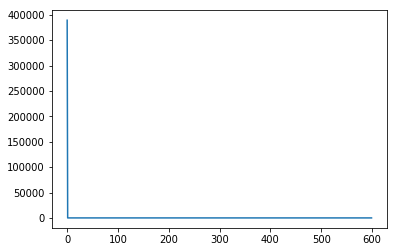

0.7353333333333333
([[694, 117], [280, 409]], 0.7353333333333333)
15 0.001
epoch 0: err 2475782.731960
epoch 1: err 526322.607630
epoch 2: err 114134.752308
epoch 3: err 25349.955888
epoch 4: err 5807.665940
epoch 5: err 1389.541246
epoch 6: err 354.635441
epoch 7: err 99.862456
epoch 8: err 32.519023
epoch 9: err 12.884588
epoch 10: err 6.417958
epoch 11: err 3.993868
epoch 12: err 2.974271
epoch 13: err 2.505771
epoch 14: err 2.276452
epoch 15: err 2.158860
epoch 16: err 2.096210
epoch 17: err 2.061624
epoch 18: err 2.041843
epoch 19: err 2.030115
epoch 20: err 2.022910
epoch 21: err 2.018326
epoch 22: err 2.015313
epoch 23: err 2.013270
epoch 24: err 2.011842
epoch 25: err 2.010814
epoch 26: err 2.010051
epoch 27: err 2.009467
epoch 28: err 2.009003
epoch 29: err 2.008624
epoch 30: err 2.008301
epoch 31: err 2.008019
epoch 32: err 2.007765
epoch 33: err 2.007531
epoch 34: err 2.007311
epoch 35: err 2.007100
epoch 36: err 2.006896
epoch 37: err 2.006698
epoch 38: err 2.006502
epoch 3

epoch 343: err 1.959168
epoch 344: err 1.959032
epoch 345: err 1.958895
epoch 346: err 1.958759
epoch 347: err 1.958622
epoch 348: err 1.958486
epoch 349: err 1.958350
epoch 350: err 1.958214
epoch 351: err 1.958079
epoch 352: err 1.957943
epoch 353: err 1.957807
epoch 354: err 1.957672
epoch 355: err 1.957537
epoch 356: err 1.957401
epoch 357: err 1.957266
epoch 358: err 1.957131
epoch 359: err 1.956997
epoch 360: err 1.956862
epoch 361: err 1.956727
epoch 362: err 1.956593
epoch 363: err 1.956459
epoch 364: err 1.956324
epoch 365: err 1.956190
epoch 366: err 1.956057
epoch 367: err 1.955923
epoch 368: err 1.955789
epoch 369: err 1.955656
epoch 370: err 1.955522
epoch 371: err 1.955389
epoch 372: err 1.955256
epoch 373: err 1.955123
epoch 374: err 1.954990
epoch 375: err 1.954858
epoch 376: err 1.954725
epoch 377: err 1.954593
epoch 378: err 1.954460
epoch 379: err 1.954328
epoch 380: err 1.954196
epoch 381: err 1.954065
epoch 382: err 1.953933
epoch 383: err 1.953801
epoch 384: err 1

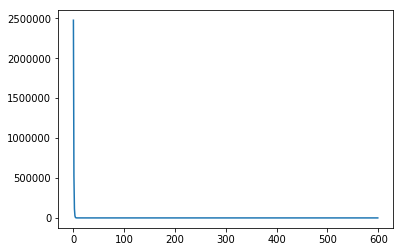

0.638
([[687, 124], [419, 270]], 0.638)
15 0.0001
epoch 0: err 372364.459950
epoch 1: err 8.832884
epoch 2: err 8.608069
epoch 3: err 9.333580
epoch 4: err 8.417861
epoch 5: err 6.523283
epoch 6: err 9.635129
epoch 7: err 9.049849
epoch 8: err 6.558494
epoch 9: err 6.341138
epoch 10: err 6.375223
epoch 11: err 6.481820
epoch 12: err 12.490267
epoch 13: err 7.535785
epoch 14: err 7596.708550
epoch 15: err 55.622603
epoch 16: err 59.738341
epoch 17: err 137.984104
epoch 18: err 571.251557
epoch 19: err 550.359670
epoch 20: err 98.023512
epoch 21: err 36.543663
epoch 22: err 43.896118
epoch 23: err 60.089104
epoch 24: err 76.840811
epoch 25: err 64.807688
epoch 26: err 60.654301
epoch 27: err 18.728334
epoch 28: err 9.204147
epoch 29: err 11.479136
epoch 30: err 15.050971
epoch 31: err 12.817595
epoch 32: err 12.855549
epoch 33: err 13.442877
epoch 34: err 12.178908
epoch 35: err 11.700871
epoch 36: err 11.255492
epoch 37: err 10.881271
epoch 38: err 10.470592
epoch 39: err 10.108017
epoc

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


epoch 285: err nan
epoch 286: err nan
epoch 287: err nan
epoch 288: err nan
epoch 289: err nan
epoch 290: err nan
epoch 291: err nan
epoch 292: err nan
epoch 293: err nan
epoch 294: err nan
epoch 295: err nan
epoch 296: err nan
epoch 297: err nan
epoch 298: err nan
epoch 299: err nan
epoch 300: err nan
epoch 301: err nan
epoch 302: err nan
epoch 303: err nan
epoch 304: err nan
epoch 305: err nan
epoch 306: err nan
epoch 307: err nan
epoch 308: err nan
epoch 309: err nan
epoch 310: err nan
epoch 311: err nan
epoch 312: err nan
epoch 313: err nan
epoch 314: err nan
epoch 315: err nan
epoch 316: err nan
epoch 317: err nan
epoch 318: err nan
epoch 319: err nan
epoch 320: err nan
epoch 321: err nan
epoch 322: err nan
epoch 323: err nan
epoch 324: err nan
epoch 325: err nan
epoch 326: err nan
epoch 327: err nan
epoch 328: err nan
epoch 329: err nan
epoch 330: err nan
epoch 331: err nan
epoch 332: err nan
epoch 333: err nan
epoch 334: err nan
epoch 335: err nan
epoch 336: err nan
epoch 337: e

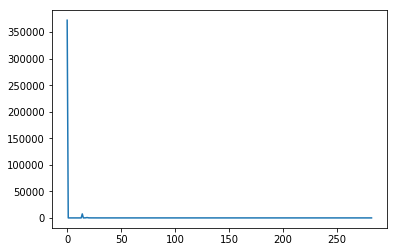

0.4593333333333333
([[0, 811], [0, 689]], 0.4593333333333333)
20 1
epoch 0: err 62877.041734


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater


epoch 1: err 3.924371
epoch 2: err 4.208927
epoch 3: err 4.762730
epoch 4: err 4.850009
epoch 5: err 4.692451
epoch 6: err 4.426511
epoch 7: err 4.164556
epoch 8: err 3.941115
epoch 9: err 3.755477
epoch 10: err 3.602007
epoch 11: err 3.477233
epoch 12: err 3.378690
epoch 13: err 3.303165
epoch 14: err 3.246467
epoch 15: err 3.204120
epoch 16: err 3.172047
epoch 17: err 3.146921
epoch 18: err 3.126235
epoch 19: err 3.108216
epoch 20: err 3.091657
epoch 21: err 3.075748
epoch 22: err 3.059930
epoch 23: err 3.043816
epoch 24: err 3.027143
epoch 25: err 3.009752
epoch 26: err 2.991574
epoch 27: err 2.972615
epoch 28: err 2.952936
epoch 29: err 2.932637
epoch 30: err 2.911838
epoch 31: err 2.890669
epoch 32: err 2.869254
epoch 33: err 2.847705
epoch 34: err 2.826115
epoch 35: err 2.804549
epoch 36: err 2.783038
epoch 37: err 2.761583
epoch 38: err 2.740153
epoch 39: err 2.718688
epoch 40: err 2.697116
epoch 41: err 2.675359
epoch 42: err 2.653347
epoch 43: err 2.631033
epoch 44: err 2.6084

epoch 349: err 1.899894
epoch 350: err 1.899626
epoch 351: err 1.899361
epoch 352: err 1.899098
epoch 353: err 1.898836
epoch 354: err 1.898576
epoch 355: err 1.898317
epoch 356: err 1.898059
epoch 357: err 1.897801
epoch 358: err 1.897543
epoch 359: err 1.897283
epoch 360: err 1.897023
epoch 361: err 1.896761
epoch 362: err 1.896496
epoch 363: err 1.896229
epoch 364: err 1.895959
epoch 365: err 1.895684
epoch 366: err 1.895406
epoch 367: err 1.895122
epoch 368: err 1.894833
epoch 369: err 1.894539
epoch 370: err 1.894238
epoch 371: err 1.893931
epoch 372: err 1.893616
epoch 373: err 1.893295
epoch 374: err 1.892965
epoch 375: err 1.892628
epoch 376: err 1.892283
epoch 377: err 1.891929
epoch 378: err 1.891567
epoch 379: err 1.891196
epoch 380: err 1.890817
epoch 381: err 1.890429
epoch 382: err 1.890032
epoch 383: err 1.889626
epoch 384: err 1.889212
epoch 385: err 1.888790
epoch 386: err 1.888359
epoch 387: err 1.887920
epoch 388: err 1.887473
epoch 389: err 1.887018
epoch 390: err 1

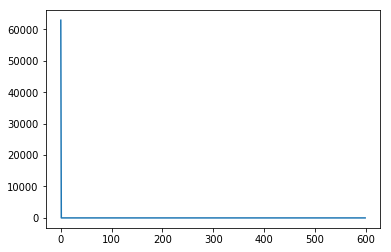

0.7766666666666666
([[739, 72], [263, 426]], 0.7766666666666666)
20 0.1
epoch 0: err 860777.316627
epoch 1: err 2.113227
epoch 2: err 2.094861
epoch 3: err 2.079931
epoch 4: err 2.068441
epoch 5: err 2.061250
epoch 6: err 2.059597
epoch 7: err 2.064396
epoch 8: err 2.075534
epoch 9: err 2.091579
epoch 10: err 2.110146
epoch 11: err 2.128667
epoch 12: err 2.145065
epoch 13: err 2.158081
epoch 14: err 2.167276
epoch 15: err 2.172850
epoch 16: err 2.175441
epoch 17: err 2.175918
epoch 18: err 2.175199
epoch 19: err 2.174095
epoch 20: err 2.173194
epoch 21: err 2.172818
epoch 22: err 2.173053
epoch 23: err 2.173833
epoch 24: err 2.175052
epoch 25: err 2.176647
epoch 26: err 2.178656
epoch 27: err 2.181224
epoch 28: err 2.184581
epoch 29: err 2.188999
epoch 30: err 2.194738
epoch 31: err 2.202013
epoch 32: err 2.210959
epoch 33: err 2.221629
epoch 34: err 2.233988
epoch 35: err 2.247925
epoch 36: err 2.263270
epoch 37: err 2.279810
epoch 38: err 2.297306
epoch 39: err 2.315506
epoch 40: err

epoch 343: err 2.404142
epoch 344: err 2.402000
epoch 345: err 2.399857
epoch 346: err 2.397713
epoch 347: err 2.395567
epoch 348: err 2.393421
epoch 349: err 2.391273
epoch 350: err 2.389124
epoch 351: err 2.386974
epoch 352: err 2.384823
epoch 353: err 2.382671
epoch 354: err 2.380518
epoch 355: err 2.378364
epoch 356: err 2.376208
epoch 357: err 2.374052
epoch 358: err 2.371895
epoch 359: err 2.369736
epoch 360: err 2.367576
epoch 361: err 2.365415
epoch 362: err 2.363253
epoch 363: err 2.361090
epoch 364: err 2.358924
epoch 365: err 2.356758
epoch 366: err 2.354590
epoch 367: err 2.352420
epoch 368: err 2.350248
epoch 369: err 2.348075
epoch 370: err 2.345900
epoch 371: err 2.343722
epoch 372: err 2.341543
epoch 373: err 2.339361
epoch 374: err 2.337177
epoch 375: err 2.334991
epoch 376: err 2.332802
epoch 377: err 2.330610
epoch 378: err 2.328415
epoch 379: err 2.326218
epoch 380: err 2.324017
epoch 381: err 2.321814
epoch 382: err 2.319607
epoch 383: err 2.317397
epoch 384: err 2

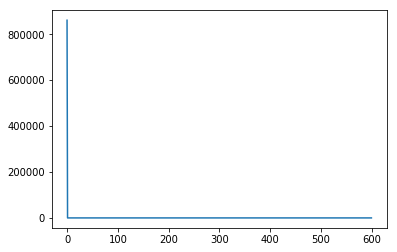

0.7673333333333333
([[717, 94], [255, 434]], 0.7673333333333333)
20 0.01
epoch 0: err 6451294.066015
epoch 1: err 2.248831
epoch 2: err 2.028691
epoch 3: err 2.026221
epoch 4: err 2.024115
epoch 5: err 2.022072
epoch 6: err 2.020085
epoch 7: err 2.018151
epoch 8: err 2.016269
epoch 9: err 2.014434
epoch 10: err 2.012646
epoch 11: err 2.010901
epoch 12: err 2.009198
epoch 13: err 2.007534
epoch 14: err 2.005909
epoch 15: err 2.004320
epoch 16: err 2.002766
epoch 17: err 2.001245
epoch 18: err 1.999757
epoch 19: err 1.998301
epoch 20: err 1.996875
epoch 21: err 1.995479
epoch 22: err 1.994112
epoch 23: err 1.992773
epoch 24: err 1.991461
epoch 25: err 1.990178
epoch 26: err 1.988921
epoch 27: err 1.987691
epoch 28: err 1.986488
epoch 29: err 1.985312
epoch 30: err 1.984162
epoch 31: err 1.983039
epoch 32: err 1.981943
epoch 33: err 1.980874
epoch 34: err 1.979832
epoch 35: err 1.978819
epoch 36: err 1.977834
epoch 37: err 1.976878
epoch 38: err 1.975951
epoch 39: err 1.975055
epoch 40: e

epoch 345: err 2.120358
epoch 346: err 2.121992
epoch 347: err 2.123641
epoch 348: err 2.125304
epoch 349: err 2.126981
epoch 350: err 2.128672
epoch 351: err 2.130376
epoch 352: err 2.132094
epoch 353: err 2.133825
epoch 354: err 2.135568
epoch 355: err 2.137324
epoch 356: err 2.139093
epoch 357: err 2.140873
epoch 358: err 2.142665
epoch 359: err 2.144469
epoch 360: err 2.146284
epoch 361: err 2.148110
epoch 362: err 2.149947
epoch 363: err 2.151795
epoch 364: err 2.153652
epoch 365: err 2.155520
epoch 366: err 2.157397
epoch 367: err 2.159284
epoch 368: err 2.161179
epoch 369: err 2.163084
epoch 370: err 2.164997
epoch 371: err 2.166919
epoch 372: err 2.168849
epoch 373: err 2.170786
epoch 374: err 2.172731
epoch 375: err 2.174684
epoch 376: err 2.176643
epoch 377: err 2.178609
epoch 378: err 2.180581
epoch 379: err 2.182560
epoch 380: err 2.184544
epoch 381: err 2.186534
epoch 382: err 2.188530
epoch 383: err 2.190530
epoch 384: err 2.192535
epoch 385: err 2.194545
epoch 386: err 2

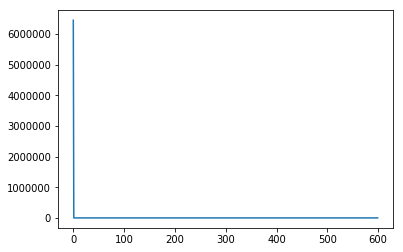

0.736
([[694, 117], [279, 410]], 0.736)
20 0.001
epoch 0: err 43703918.517756
epoch 1: err 5403341.583538
epoch 2: err 684192.540159
epoch 3: err 89185.492359
epoch 4: err 12089.587967
epoch 5: err 1740.961818
epoch 6: err 278.474524
epoch 7: err 53.821213
epoch 8: err 14.203928
epoch 9: err 5.642951
epoch 10: err 3.309931
epoch 11: err 2.537578
epoch 12: err 2.246230
epoch 13: err 2.126419
epoch 14: err 2.073658
epoch 15: err 2.048864
epoch 16: err 2.036430
epoch 17: err 2.029791
epoch 18: err 2.026035
epoch 19: err 2.023794
epoch 20: err 2.022389
epoch 21: err 2.021462
epoch 22: err 2.020816
epoch 23: err 2.020338
epoch 24: err 2.019962
epoch 25: err 2.019649
epoch 26: err 2.019374
epoch 27: err 2.019124
epoch 28: err 2.018888
epoch 29: err 2.018662
epoch 30: err 2.018442
epoch 31: err 2.018226
epoch 32: err 2.018013
epoch 33: err 2.017802
epoch 34: err 2.017592
epoch 35: err 2.017383
epoch 36: err 2.017176
epoch 37: err 2.016969
epoch 38: err 2.016762
epoch 39: err 2.016557
epoch 40

epoch 344: err 1.972382
epoch 345: err 1.972282
epoch 346: err 1.972182
epoch 347: err 1.972083
epoch 348: err 1.971984
epoch 349: err 1.971885
epoch 350: err 1.971787
epoch 351: err 1.971689
epoch 352: err 1.971591
epoch 353: err 1.971493
epoch 354: err 1.971396
epoch 355: err 1.971299
epoch 356: err 1.971202
epoch 357: err 1.971105
epoch 358: err 1.971009
epoch 359: err 1.970913
epoch 360: err 1.970817
epoch 361: err 1.970722
epoch 362: err 1.970627
epoch 363: err 1.970532
epoch 364: err 1.970438
epoch 365: err 1.970343
epoch 366: err 1.970249
epoch 367: err 1.970156
epoch 368: err 1.970062
epoch 369: err 1.969969
epoch 370: err 1.969876
epoch 371: err 1.969784
epoch 372: err 1.969691
epoch 373: err 1.969599
epoch 374: err 1.969508
epoch 375: err 1.969416
epoch 376: err 1.969325
epoch 377: err 1.969234
epoch 378: err 1.969144
epoch 379: err 1.969054
epoch 380: err 1.968964
epoch 381: err 1.968874
epoch 382: err 1.968785
epoch 383: err 1.968695
epoch 384: err 1.968607
epoch 385: err 1

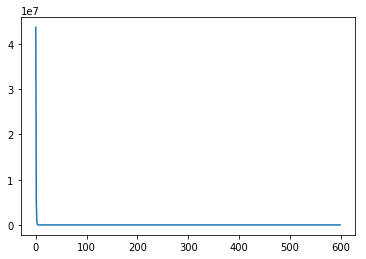

0.6226666666666667
([[658, 153], [413, 276]], 0.6226666666666667)
20 0.0001
epoch 0: err 412496643.184806
epoch 1: err 9.130466
epoch 2: err 11.158898
epoch 3: err 16.263673
epoch 4: err 16.547481
epoch 5: err 11.025447
epoch 6: err 9.234022
epoch 7: err 13.200309
epoch 8: err 10.434618
epoch 9: err 8.051229
epoch 10: err 10.920330
epoch 11: err 11.153430
epoch 12: err 10.346929
epoch 13: err 10.427599
epoch 14: err 10.197067
epoch 15: err 9.160507
epoch 16: err 19.027692
epoch 17: err 12.339105
epoch 18: err 19.205111
epoch 19: err 36.094463
epoch 20: err 17.320504
epoch 21: err 13.203161
epoch 22: err 12.351788
epoch 23: err 10.457148
epoch 24: err 8.373879
epoch 25: err 7.027188
epoch 26: err 5.411984
epoch 27: err 5.373467
epoch 28: err 4.377802
epoch 29: err 4.399075
epoch 30: err 4.473683
epoch 31: err 4.318330
epoch 32: err 9.056288
epoch 33: err 4.550317
epoch 34: err 7.250689
epoch 35: err 4.750337
epoch 36: err 5.270944
epoch 37: err 4.260306
epoch 38: err 4.728149
epoch 39: 

epoch 345: err 6.050024
epoch 346: err 6.045925
epoch 347: err 6.041455
epoch 348: err 6.036625
epoch 349: err 6.031472
epoch 350: err 6.026044
epoch 351: err 6.020396
epoch 352: err 6.014583
epoch 353: err 6.008653
epoch 354: err 6.002648
epoch 355: err 5.996600
epoch 356: err 5.990537
epoch 357: err 5.984481
epoch 358: err 5.978449
epoch 359: err 5.972458
epoch 360: err 5.966520
epoch 361: err 5.960647
epoch 362: err 5.954849
epoch 363: err 5.949133
epoch 364: err 5.943507
epoch 365: err 5.937975
epoch 366: err 5.932540
epoch 367: err 5.927203
epoch 368: err 5.921960
epoch 369: err 5.916810
epoch 370: err 5.911744
epoch 371: err 5.906756
epoch 372: err 5.901836
epoch 373: err 5.896976
epoch 374: err 5.892165
epoch 375: err 5.887396
epoch 376: err 5.882660
epoch 377: err 5.877952
epoch 378: err 5.873267
epoch 379: err 5.868604
epoch 380: err 5.863960
epoch 381: err 5.859339
epoch 382: err 5.854742
epoch 383: err 5.850173
epoch 384: err 5.845637
epoch 385: err 5.841139
epoch 386: err 5

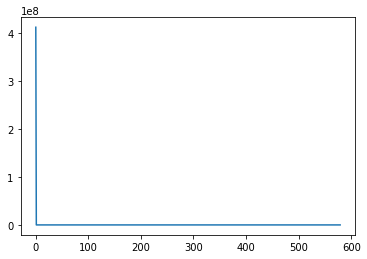

0.4593333333333333
([[0, 811], [0, 689]], 0.4593333333333333)
25 1
epoch 0: err 740193.303557
epoch 1: err 4.734183
epoch 2: err 5.457656
epoch 3: err 6.004188
epoch 4: err 5.890146
epoch 5: err 5.464906
epoch 6: err 4.969589
epoch 7: err 4.537852
epoch 8: err 4.197802
epoch 9: err 3.937384
epoch 10: err 3.738089
epoch 11: err 3.584234
epoch 12: err 3.464053
epoch 13: err 3.368915
epoch 14: err 3.292412
epoch 15: err 3.229684
epoch 16: err 3.176990
epoch 17: err 3.131453
epoch 18: err 3.090895
epoch 19: err 3.053723
epoch 20: err 3.018818
epoch 21: err 2.985427
epoch 22: err 2.953065
epoch 23: err 2.921434
epoch 24: err 2.890362
epoch 25: err 2.859763
epoch 26: err 2.829615
epoch 27: err 2.799949
epoch 28: err 2.770839
epoch 29: err 2.742391
epoch 30: err 2.714731
epoch 31: err 2.687989
epoch 32: err 2.662289
epoch 33: err 2.637735
epoch 34: err 2.614407
epoch 35: err 2.592354
epoch 36: err 2.571599
epoch 37: err 2.552135
epoch 38: err 2.533934
epoch 39: err 2.516946
epoch 40: err 2.50

epoch 346: err 1.971800
epoch 347: err 1.971654
epoch 348: err 1.971507
epoch 349: err 1.971360
epoch 350: err 1.971213
epoch 351: err 1.971066
epoch 352: err 1.970918
epoch 353: err 1.970769
epoch 354: err 1.970619
epoch 355: err 1.970469
epoch 356: err 1.970318
epoch 357: err 1.970166
epoch 358: err 1.970013
epoch 359: err 1.969859
epoch 360: err 1.969703
epoch 361: err 1.969546
epoch 362: err 1.969389
epoch 363: err 1.969229
epoch 364: err 1.969069
epoch 365: err 1.968907
epoch 366: err 1.968744
epoch 367: err 1.968579
epoch 368: err 1.968412
epoch 369: err 1.968245
epoch 370: err 1.968075
epoch 371: err 1.967905
epoch 372: err 1.967732
epoch 373: err 1.967559
epoch 374: err 1.967383
epoch 375: err 1.967207
epoch 376: err 1.967029
epoch 377: err 1.966849
epoch 378: err 1.966668
epoch 379: err 1.966486
epoch 380: err 1.966302
epoch 381: err 1.966117
epoch 382: err 1.965931
epoch 383: err 1.965744
epoch 384: err 1.965556
epoch 385: err 1.965367
epoch 386: err 1.965176
epoch 387: err 1

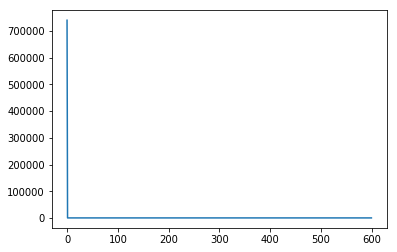

0.778
([[730, 81], [252, 437]], 0.778)
25 0.1
epoch 0: err 18797398.501099
epoch 1: err 2.130011
epoch 2: err 2.105157
epoch 3: err 2.086227
epoch 4: err 2.072791
epoch 5: err 2.065700
epoch 6: err 2.066040
epoch 7: err 2.074114
epoch 8: err 2.088767
epoch 9: err 2.107488
epoch 10: err 2.127195
epoch 11: err 2.145223
epoch 12: err 2.159940
epoch 13: err 2.170864
epoch 14: err 2.178395
epoch 15: err 2.183409
epoch 16: err 2.186861
epoch 17: err 2.189508
epoch 18: err 2.191774
epoch 19: err 2.193785
epoch 20: err 2.195499
epoch 21: err 2.196872
epoch 22: err 2.197968
epoch 23: err 2.199004
epoch 24: err 2.200315
epoch 25: err 2.202287
epoch 26: err 2.205286
epoch 27: err 2.209605
epoch 28: err 2.215437
epoch 29: err 2.222868
epoch 30: err 2.231890
epoch 31: err 2.242421
epoch 32: err 2.254317
epoch 33: err 2.267401
epoch 34: err 2.281469
epoch 35: err 2.296309
epoch 36: err 2.311709
epoch 37: err 2.327464
epoch 38: err 2.343380
epoch 39: err 2.359282
epoch 40: err 2.375009
epoch 41: err 

epoch 347: err 2.283092
epoch 348: err 2.280185
epoch 349: err 2.277292
epoch 350: err 2.274415
epoch 351: err 2.271552
epoch 352: err 2.268705
epoch 353: err 2.265873
epoch 354: err 2.263057
epoch 355: err 2.260258
epoch 356: err 2.257475
epoch 357: err 2.254709
epoch 358: err 2.251959
epoch 359: err 2.249227
epoch 360: err 2.246512
epoch 361: err 2.243815
epoch 362: err 2.241136
epoch 363: err 2.238474
epoch 364: err 2.235831
epoch 365: err 2.233206
epoch 366: err 2.230599
epoch 367: err 2.228011
epoch 368: err 2.225442
epoch 369: err 2.222892
epoch 370: err 2.220360
epoch 371: err 2.217847
epoch 372: err 2.215354
epoch 373: err 2.212880
epoch 374: err 2.210425
epoch 375: err 2.207989
epoch 376: err 2.205573
epoch 377: err 2.203176
epoch 378: err 2.200799
epoch 379: err 2.198441
epoch 380: err 2.196103
epoch 381: err 2.193785
epoch 382: err 2.191486
epoch 383: err 2.189207
epoch 384: err 2.186947
epoch 385: err 2.184707
epoch 386: err 2.182487
epoch 387: err 2.180287
epoch 388: err 2

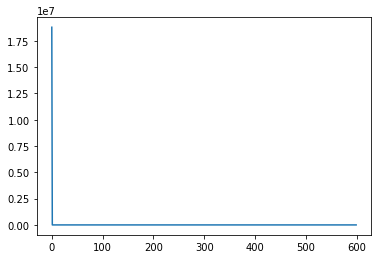

0.7726666666666666
([[744, 67], [274, 415]], 0.7726666666666666)
25 0.01
epoch 0: err 135132357.340851
epoch 1: err 2.114017
epoch 2: err 2.032313
epoch 3: err 2.028917
epoch 4: err 2.025693
epoch 5: err 2.022596
epoch 6: err 2.019618
epoch 7: err 2.016750
epoch 8: err 2.013986
epoch 9: err 2.011318
epoch 10: err 2.008740
epoch 11: err 2.006247
epoch 12: err 2.003833
epoch 13: err 2.001495
epoch 14: err 1.999226
epoch 15: err 1.997025
epoch 16: err 1.994887
epoch 17: err 1.992809
epoch 18: err 1.990788
epoch 19: err 1.988821
epoch 20: err 1.986907
epoch 21: err 1.985043
epoch 22: err 1.983228
epoch 23: err 1.981459
epoch 24: err 1.979736
epoch 25: err 1.978056
epoch 26: err 1.976420
epoch 27: err 1.974826
epoch 28: err 1.973274
epoch 29: err 1.971762
epoch 30: err 1.970291
epoch 31: err 1.968860
epoch 32: err 1.967469
epoch 33: err 1.966118
epoch 34: err 1.964807
epoch 35: err 1.963537
epoch 36: err 1.962307
epoch 37: err 1.961119
epoch 38: err 1.959971
epoch 39: err 1.958866
epoch 40:

epoch 343: err 2.127556
epoch 344: err 2.129142
epoch 345: err 2.130732
epoch 346: err 2.132326
epoch 347: err 2.133924
epoch 348: err 2.135526
epoch 349: err 2.137132
epoch 350: err 2.138742
epoch 351: err 2.140355
epoch 352: err 2.141971
epoch 353: err 2.143589
epoch 354: err 2.145211
epoch 355: err 2.146835
epoch 356: err 2.148461
epoch 357: err 2.150089
epoch 358: err 2.151720
epoch 359: err 2.153352
epoch 360: err 2.154985
epoch 361: err 2.156620
epoch 362: err 2.158256
epoch 363: err 2.159892
epoch 364: err 2.161530
epoch 365: err 2.163168
epoch 366: err 2.164806
epoch 367: err 2.166445
epoch 368: err 2.168084
epoch 369: err 2.169722
epoch 370: err 2.171360
epoch 371: err 2.172998
epoch 372: err 2.174635
epoch 373: err 2.176271
epoch 374: err 2.177906
epoch 375: err 2.179541
epoch 376: err 2.181173
epoch 377: err 2.182804
epoch 378: err 2.184434
epoch 379: err 2.186062
epoch 380: err 2.187688
epoch 381: err 2.189311
epoch 382: err 2.190933
epoch 383: err 2.192552
epoch 384: err 2

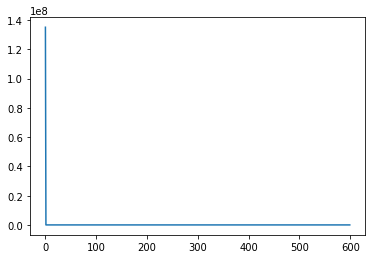

0.7386666666666667
([[691, 120], [272, 417]], 0.7386666666666667)
25 0.001
epoch 0: err 868311339.673674
epoch 1: err 64113288.517475
epoch 2: err 4873321.382456
epoch 3: err 383314.602295
epoch 4: err 31530.594872
epoch 5: err 2782.553186
epoch 6: err 281.188285
epoch 7: err 37.799755
epoch 8: err 8.549988
epoch 9: err 3.672789
epoch 10: err 2.537379
epoch 11: err 2.206781
epoch 12: err 2.096736
epoch 13: err 2.056075
epoch 14: err 2.039420
epoch 15: err 2.031857
epoch 16: err 2.028072
epoch 17: err 2.025998
epoch 18: err 2.024754
epoch 19: err 2.023933
epoch 20: err 2.023335
epoch 21: err 2.022856
epoch 22: err 2.022442
epoch 23: err 2.022065
epoch 24: err 2.021708
epoch 25: err 2.021362
epoch 26: err 2.021024
epoch 27: err 2.020690
epoch 28: err 2.020359
epoch 29: err 2.020031
epoch 30: err 2.019704
epoch 31: err 2.019379
epoch 32: err 2.019056
epoch 33: err 2.018734
epoch 34: err 2.018413
epoch 35: err 2.018094
epoch 36: err 2.017776
epoch 37: err 2.017459
epoch 38: err 2.017144
ep

epoch 343: err 1.956242
epoch 344: err 1.956116
epoch 345: err 1.955991
epoch 346: err 1.955866
epoch 347: err 1.955741
epoch 348: err 1.955617
epoch 349: err 1.955493
epoch 350: err 1.955369
epoch 351: err 1.955246
epoch 352: err 1.955123
epoch 353: err 1.955001
epoch 354: err 1.954879
epoch 355: err 1.954757
epoch 356: err 1.954636
epoch 357: err 1.954515
epoch 358: err 1.954395
epoch 359: err 1.954275
epoch 360: err 1.954155
epoch 361: err 1.954036
epoch 362: err 1.953917
epoch 363: err 1.953799
epoch 364: err 1.953681
epoch 365: err 1.953563
epoch 366: err 1.953446
epoch 367: err 1.953329
epoch 368: err 1.953213
epoch 369: err 1.953096
epoch 370: err 1.952981
epoch 371: err 1.952866
epoch 372: err 1.952751
epoch 373: err 1.952636
epoch 374: err 1.952522
epoch 375: err 1.952408
epoch 376: err 1.952295
epoch 377: err 1.952182
epoch 378: err 1.952070
epoch 379: err 1.951958
epoch 380: err 1.951846
epoch 381: err 1.951735
epoch 382: err 1.951624
epoch 383: err 1.951513
epoch 384: err 1

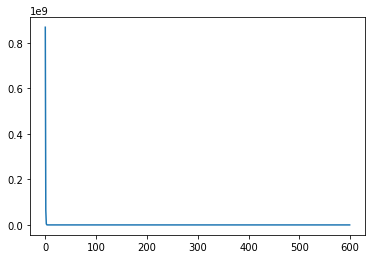

0.648
([[663, 148], [380, 309]], 0.648)
25 0.0001
epoch 0: err 28832301595.156254
epoch 1: err 9.363041
epoch 2: err 8.974386
epoch 3: err 8.626436
epoch 4: err 7.903555
epoch 5: err 7.648608
epoch 6: err 10.252306
epoch 7: err 19.816544
epoch 8: err 43.378293
epoch 9: err 61.222145
epoch 10: err 34.548070
epoch 11: err 17.667733
epoch 12: err 14.012876
epoch 13: err 8.046600
epoch 14: err 6.787569
epoch 15: err 7.454700
epoch 16: err 8.347609
epoch 17: err 9.694438
epoch 18: err 13.722207
epoch 19: err 12.699333
epoch 20: err 7.049069
epoch 21: err 5.565177
epoch 22: err 6.259591
epoch 23: err 9.951763
epoch 24: err 14.895263
epoch 25: err 12.130950
epoch 26: err 11.328752
epoch 27: err 12.926260
epoch 28: err 13.757161
epoch 29: err 13.211205
epoch 30: err 13.643113
epoch 31: err 16.110132
epoch 32: err 19.598661
epoch 33: err 23.668612
epoch 34: err 24.218876
epoch 35: err 21.124726
epoch 36: err 22.574662
epoch 37: err 19.364939
epoch 38: err 28.454177
epoch 39: err 26.253952
epoch

epoch 399: err nan
epoch 400: err nan
epoch 401: err nan
epoch 402: err nan
epoch 403: err nan
epoch 404: err nan
epoch 405: err nan
epoch 406: err nan
epoch 407: err nan
epoch 408: err nan
epoch 409: err nan
epoch 410: err nan
epoch 411: err nan
epoch 412: err nan
epoch 413: err nan
epoch 414: err nan
epoch 415: err nan
epoch 416: err nan
epoch 417: err nan
epoch 418: err nan
epoch 419: err nan
epoch 420: err nan
epoch 421: err nan
epoch 422: err nan
epoch 423: err nan
epoch 424: err nan
epoch 425: err nan
epoch 426: err nan
epoch 427: err nan
epoch 428: err nan
epoch 429: err nan
epoch 430: err nan
epoch 431: err nan
epoch 432: err nan
epoch 433: err nan
epoch 434: err nan
epoch 435: err nan
epoch 436: err nan
epoch 437: err nan
epoch 438: err nan
epoch 439: err nan
epoch 440: err nan
epoch 441: err nan
epoch 442: err nan
epoch 443: err nan
epoch 444: err nan
epoch 445: err nan
epoch 446: err nan
epoch 447: err nan
epoch 448: err nan
epoch 449: err nan
epoch 450: err nan
epoch 451: e

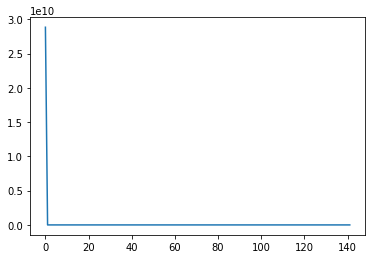

0.4593333333333333
([[0, 811], [0, 689]], 0.4593333333333333)
28 1
epoch 0: err 178080199.472827
epoch 1: err 6.128758
epoch 2: err 7.301409
epoch 3: err 7.711661
epoch 4: err 7.087922
epoch 5: err 6.218557
epoch 6: err 5.420486
epoch 7: err 4.810989
epoch 8: err 4.378481
epoch 9: err 4.077799
epoch 10: err 3.869331
epoch 11: err 3.724929
epoch 12: err 3.625192
epoch 13: err 3.556459
epoch 14: err 3.508863
epoch 15: err 3.475191
epoch 16: err 3.450170
epoch 17: err 3.430002
epoch 18: err 3.412030
epoch 19: err 3.394497
epoch 20: err 3.376334
epoch 21: err 3.356998
epoch 22: err 3.336317
epoch 23: err 3.314368
epoch 24: err 3.291376
epoch 25: err 3.267642
epoch 26: err 3.243489
epoch 27: err 3.219231
epoch 28: err 3.195155
epoch 29: err 3.171514
epoch 30: err 3.148525
epoch 31: err 3.126369
epoch 32: err 3.105193
epoch 33: err 3.085105
epoch 34: err 3.066177
epoch 35: err 3.048438
epoch 36: err 3.031878
epoch 37: err 3.016449
epoch 38: err 3.002065
epoch 39: err 2.988611
epoch 40: err 2

epoch 346: err 1.899730
epoch 347: err 1.899277
epoch 348: err 1.898825
epoch 349: err 1.898376
epoch 350: err 1.897927
epoch 351: err 1.897481
epoch 352: err 1.897036
epoch 353: err 1.896593
epoch 354: err 1.896151
epoch 355: err 1.895711
epoch 356: err 1.895272
epoch 357: err 1.894834
epoch 358: err 1.894398
epoch 359: err 1.893964
epoch 360: err 1.893531
epoch 361: err 1.893099
epoch 362: err 1.892668
epoch 363: err 1.892239
epoch 364: err 1.891812
epoch 365: err 1.891385
epoch 366: err 1.890960
epoch 367: err 1.890536
epoch 368: err 1.890114
epoch 369: err 1.889693
epoch 370: err 1.889273
epoch 371: err 1.888854
epoch 372: err 1.888436
epoch 373: err 1.888020
epoch 374: err 1.887605
epoch 375: err 1.887192
epoch 376: err 1.886779
epoch 377: err 1.886368
epoch 378: err 1.885958
epoch 379: err 1.885549
epoch 380: err 1.885141
epoch 381: err 1.884735
epoch 382: err 1.884330
epoch 383: err 1.883926
epoch 384: err 1.883523
epoch 385: err 1.883121
epoch 386: err 1.882721
epoch 387: err 1

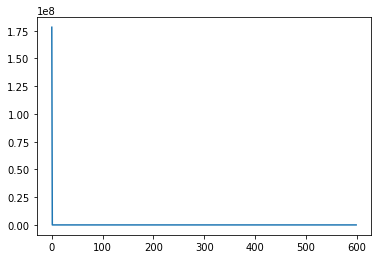

0.778
([[733, 78], [255, 434]], 0.778)
28 0.1
epoch 0: err 4413922886.186703
epoch 1: err 2.152463
epoch 2: err 2.125113
epoch 3: err 2.102487
epoch 4: err 2.085407
epoch 5: err 2.075906
epoch 6: err 2.075976
epoch 7: err 2.086149
epoch 8: err 2.104705
epoch 9: err 2.128121
epoch 10: err 2.152418
epoch 11: err 2.174426
epoch 12: err 2.192367
epoch 13: err 2.205776
epoch 14: err 2.215107
epoch 15: err 2.221294
epoch 16: err 2.225401
epoch 17: err 2.228388
epoch 18: err 2.230973
epoch 19: err 2.233594
epoch 20: err 2.236431
epoch 21: err 2.239497
epoch 22: err 2.242731
epoch 23: err 2.246093
epoch 24: err 2.249621
epoch 25: err 2.253442
epoch 26: err 2.257761
epoch 27: err 2.262820
epoch 28: err 2.268858
epoch 29: err 2.276073
epoch 30: err 2.284604
epoch 31: err 2.294513
epoch 32: err 2.305791
epoch 33: err 2.318367
epoch 34: err 2.332118
epoch 35: err 2.346882
epoch 36: err 2.362477
epoch 37: err 2.378706
epoch 38: err 2.395374
epoch 39: err 2.412287
epoch 40: err 2.429266
epoch 41: er

epoch 346: err 2.461113
epoch 347: err 2.459653
epoch 348: err 2.458197
epoch 349: err 2.456743
epoch 350: err 2.455293
epoch 351: err 2.453845
epoch 352: err 2.452400
epoch 353: err 2.450958
epoch 354: err 2.449519
epoch 355: err 2.448083
epoch 356: err 2.446649
epoch 357: err 2.445218
epoch 358: err 2.443789
epoch 359: err 2.442362
epoch 360: err 2.440938
epoch 361: err 2.439516
epoch 362: err 2.438096
epoch 363: err 2.436678
epoch 364: err 2.435262
epoch 365: err 2.433848
epoch 366: err 2.432435
epoch 367: err 2.431024
epoch 368: err 2.429615
epoch 369: err 2.428207
epoch 370: err 2.426801
epoch 371: err 2.425396
epoch 372: err 2.423992
epoch 373: err 2.422590
epoch 374: err 2.421188
epoch 375: err 2.419788
epoch 376: err 2.418388
epoch 377: err 2.416989
epoch 378: err 2.415590
epoch 379: err 2.414192
epoch 380: err 2.412795
epoch 381: err 2.411397
epoch 382: err 2.410000
epoch 383: err 2.408603
epoch 384: err 2.407207
epoch 385: err 2.405810
epoch 386: err 2.404413
epoch 387: err 2

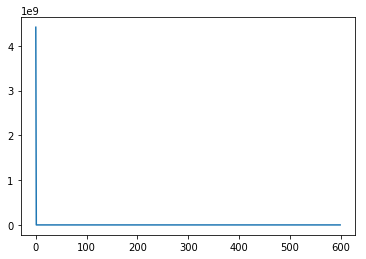

0.77
([[738, 73], [272, 417]], 0.77)
28 0.01
epoch 0: err 36871406778.187874
epoch 1: err 2.188989
epoch 2: err 2.030169
epoch 3: err 2.027146
epoch 4: err 2.024233
epoch 5: err 2.021402
epoch 6: err 2.018649
epoch 7: err 2.015967
epoch 8: err 2.013354
epoch 9: err 2.010804
epoch 10: err 2.008314
epoch 11: err 2.005881
epoch 12: err 2.003501
epoch 13: err 2.001172
epoch 14: err 1.998891
epoch 15: err 1.996656
epoch 16: err 1.994465
epoch 17: err 1.992317
epoch 18: err 1.990210
epoch 19: err 1.988142
epoch 20: err 1.986113
epoch 21: err 1.984122
epoch 22: err 1.982168
epoch 23: err 1.980251
epoch 24: err 1.978370
epoch 25: err 1.976525
epoch 26: err 1.974717
epoch 27: err 1.972944
epoch 28: err 1.971209
epoch 29: err 1.969510
epoch 30: err 1.967849
epoch 31: err 1.966226
epoch 32: err 1.964642
epoch 33: err 1.963098
epoch 34: err 1.961596
epoch 35: err 1.960136
epoch 36: err 1.958719
epoch 37: err 1.957347
epoch 38: err 1.956021
epoch 39: err 1.954743
epoch 40: err 1.953514
epoch 41: er

epoch 346: err 2.153496
epoch 347: err 2.154986
epoch 348: err 2.156483
epoch 349: err 2.157987
epoch 350: err 2.159497
epoch 351: err 2.161014
epoch 352: err 2.162538
epoch 353: err 2.164068
epoch 354: err 2.165604
epoch 355: err 2.167146
epoch 356: err 2.168693
epoch 357: err 2.170246
epoch 358: err 2.171804
epoch 359: err 2.173367
epoch 360: err 2.174936
epoch 361: err 2.176509
epoch 362: err 2.178086
epoch 363: err 2.179668
epoch 364: err 2.181254
epoch 365: err 2.182844
epoch 366: err 2.184437
epoch 367: err 2.186035
epoch 368: err 2.187635
epoch 369: err 2.189239
epoch 370: err 2.190846
epoch 371: err 2.192456
epoch 372: err 2.194068
epoch 373: err 2.195683
epoch 374: err 2.197300
epoch 375: err 2.198919
epoch 376: err 2.200540
epoch 377: err 2.202163
epoch 378: err 2.203788
epoch 379: err 2.205414
epoch 380: err 2.207041
epoch 381: err 2.208669
epoch 382: err 2.210298
epoch 383: err 2.211928
epoch 384: err 2.213559
epoch 385: err 2.215189
epoch 386: err 2.216821
epoch 387: err 2

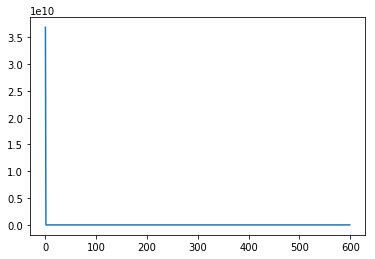

0.734
([[668, 143], [256, 433]], 0.734)
28 0.001
epoch 0: err 228287692777.975677
epoch 1: err 11136556250.394657
epoch 2: err 557789516.349378
epoch 3: err 28784515.750391
epoch 4: err 1538531.541409
epoch 5: err 86047.288536
epoch 6: err 5166.503182
epoch 7: err 358.781860
epoch 8: err 35.223842
epoch 9: err 6.918813
epoch 10: err 3.101920
epoch 11: err 2.322671
epoch 12: err 2.118943
epoch 13: err 2.056921
epoch 14: err 2.035307
epoch 15: err 2.026704
epoch 16: err 2.022836
epoch 17: err 2.020897
epoch 18: err 2.019813
epoch 19: err 2.019130
epoch 20: err 2.018640
epoch 21: err 2.018245
epoch 22: err 2.017899
epoch 23: err 2.017576
epoch 24: err 2.017267
epoch 25: err 2.016964
epoch 26: err 2.016665
epoch 27: err 2.016368
epoch 28: err 2.016073
epoch 29: err 2.015779
epoch 30: err 2.015486
epoch 31: err 2.015194
epoch 32: err 2.014904
epoch 33: err 2.014614
epoch 34: err 2.014325
epoch 35: err 2.014036
epoch 36: err 2.013749
epoch 37: err 2.013463
epoch 38: err 2.013177
epoch 39: er

epoch 345: err 1.950207
epoch 346: err 1.950063
epoch 347: err 1.949920
epoch 348: err 1.949776
epoch 349: err 1.949634
epoch 350: err 1.949491
epoch 351: err 1.949349
epoch 352: err 1.949208
epoch 353: err 1.949067
epoch 354: err 1.948926
epoch 355: err 1.948786
epoch 356: err 1.948646
epoch 357: err 1.948506
epoch 358: err 1.948367
epoch 359: err 1.948229
epoch 360: err 1.948091
epoch 361: err 1.947953
epoch 362: err 1.947816
epoch 363: err 1.947679
epoch 364: err 1.947543
epoch 365: err 1.947407
epoch 366: err 1.947271
epoch 367: err 1.947136
epoch 368: err 1.947001
epoch 369: err 1.946867
epoch 370: err 1.946733
epoch 371: err 1.946600
epoch 372: err 1.946467
epoch 373: err 1.946335
epoch 374: err 1.946203
epoch 375: err 1.946071
epoch 376: err 1.945940
epoch 377: err 1.945810
epoch 378: err 1.945679
epoch 379: err 1.945550
epoch 380: err 1.945420
epoch 381: err 1.945292
epoch 382: err 1.945163
epoch 383: err 1.945035
epoch 384: err 1.944908
epoch 385: err 1.944781
epoch 386: err 1

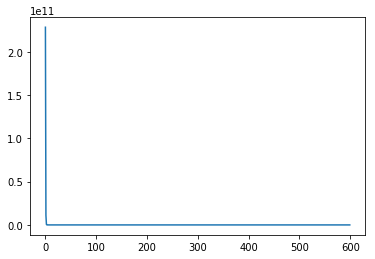

0.6493333333333333
([[631, 180], [346, 343]], 0.6493333333333333)
28 0.0001


In [47]:
# Best parameters
# HiddenNodes = 8 
# Learning Rate = 0.0001
hiddenNodes = [1, 5, 10, 15, 20, 25, 28]
learningRate = [1, 0.1, 0.01, 0.001, 0.0001]
accuracy = 0
best = []
for nodes in hiddenNodes:
    for rate in learningRate:
        a = runNN(50, nodes, rate, 600, "train")[1]
        print(nodes, rate)
        if a > accuracy:
            accuracy = a
            best = [nodes, rate]            

In [48]:
print(accuracy, best)

0.778 [25, 0.1]


epoch 0: err 206488088.866061
epoch 1: err 2.170880
epoch 2: err 2.145269
epoch 3: err 2.124974
epoch 4: err 2.110050
epoch 5: err 2.101977
epoch 6: err 2.102832
epoch 7: err 2.114098
epoch 8: err 2.135410
epoch 9: err 2.164060
epoch 10: err 2.195681
epoch 11: err 2.225654
epoch 12: err 2.250351
epoch 13: err 2.267703
epoch 14: err 2.277162
epoch 15: err 2.279338
epoch 16: err 2.275544
epoch 17: err 2.267367
epoch 18: err 2.256325
epoch 19: err 2.243634
epoch 20: err 2.230110
epoch 21: err 2.216203
epoch 22: err 2.202135
epoch 23: err 2.188079
epoch 24: err 2.174312
epoch 25: err 2.161294
epoch 26: err 2.149658
epoch 27: err 2.140132
epoch 28: err 2.133428
epoch 29: err 2.130150
epoch 30: err 2.130736
epoch 31: err 2.135441
epoch 32: err 2.144341
epoch 33: err 2.157368
epoch 34: err 2.174335
epoch 35: err 2.194974
epoch 36: err 2.218958
epoch 37: err 2.245924
epoch 38: err 2.275493
epoch 39: err 2.307279
epoch 40: err 2.340900
epoch 41: err 2.375988
epoch 42: err 2.412192
epoch 43: err

epoch 347: err 1.872396
epoch 348: err 1.870012
epoch 349: err 1.867624
epoch 350: err 1.865234
epoch 351: err 1.862841
epoch 352: err 1.860445
epoch 353: err 1.858046
epoch 354: err 1.855645
epoch 355: err 1.853242
epoch 356: err 1.850836
epoch 357: err 1.848429
epoch 358: err 1.846020
epoch 359: err 1.843609
epoch 360: err 1.841198
epoch 361: err 1.838785
epoch 362: err 1.836372
epoch 363: err 1.833958
epoch 364: err 1.831545
epoch 365: err 1.829131
epoch 366: err 1.826719
epoch 367: err 1.824307
epoch 368: err 1.821897
epoch 369: err 1.819489
epoch 370: err 1.817083
epoch 371: err 1.814680
epoch 372: err 1.812280
epoch 373: err 1.809883
epoch 374: err 1.807490
epoch 375: err 1.805101
epoch 376: err 1.802718
epoch 377: err 1.800339
epoch 378: err 1.797966
epoch 379: err 1.795599
epoch 380: err 1.793239
epoch 381: err 1.790886
epoch 382: err 1.788540
epoch 383: err 1.786202
epoch 384: err 1.783872
epoch 385: err 1.781551
epoch 386: err 1.779238
epoch 387: err 1.776936
epoch 388: err 1

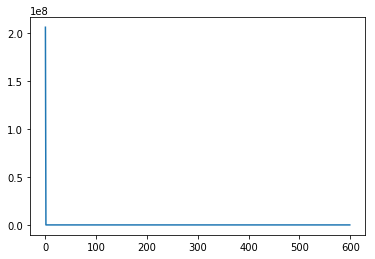

0.714
([[223, 50], [93, 134]], 0.714)


([[223, 50], [93, 134]], 0.714)

In [67]:
runNN(100, 28, 0.01, 600, "test")

## 5(D)Zero-R

In [306]:
confusion_matrix(testingLabels,['1']*500)

0.546


([[273, 0], [227, 0]], 0.546)

## 5(E)

epoch 0: err 15392721.568864
epoch 1: err 2.144600
epoch 2: err 2.119936
epoch 3: err 2.099975
epoch 4: err 2.083391
epoch 5: err 2.070081
epoch 6: err 2.060526
epoch 7: err 2.055267
epoch 8: err 2.054472
epoch 9: err 2.057696
epoch 10: err 2.063941
epoch 11: err 2.071951
epoch 12: err 2.080572
epoch 13: err 2.089006
epoch 14: err 2.096889
epoch 15: err 2.104234
epoch 16: err 2.111302
epoch 17: err 2.118459
epoch 18: err 2.126060
epoch 19: err 2.134372
epoch 20: err 2.143538
epoch 21: err 2.153582
epoch 22: err 2.164436
epoch 23: err 2.175991
epoch 24: err 2.188143
epoch 25: err 2.200831
epoch 26: err 2.214052
epoch 27: err 2.227862
epoch 28: err 2.242359
epoch 29: err 2.257658
epoch 30: err 2.273871
epoch 31: err 2.291087
epoch 32: err 2.309360
epoch 33: err 2.328705
epoch 34: err 2.349095
epoch 35: err 2.370468
epoch 36: err 2.392731
epoch 37: err 2.415770
epoch 38: err 2.439455
epoch 39: err 2.463645
epoch 40: err 2.488198
epoch 41: err 2.512974
epoch 42: err 2.537836
epoch 43: err 

epoch 347: err 2.891660
epoch 348: err 2.891559
epoch 349: err 2.891449
epoch 350: err 2.891331
epoch 351: err 2.891203
epoch 352: err 2.891067
epoch 353: err 2.890921
epoch 354: err 2.890766
epoch 355: err 2.890602
epoch 356: err 2.890429
epoch 357: err 2.890246
epoch 358: err 2.890054
epoch 359: err 2.889852
epoch 360: err 2.889640
epoch 361: err 2.889419
epoch 362: err 2.889187
epoch 363: err 2.888946
epoch 364: err 2.888695
epoch 365: err 2.888434
epoch 366: err 2.888163
epoch 367: err 2.887882
epoch 368: err 2.887591
epoch 369: err 2.887290
epoch 370: err 2.886978
epoch 371: err 2.886656
epoch 372: err 2.886324
epoch 373: err 2.885981
epoch 374: err 2.885628
epoch 375: err 2.885265
epoch 376: err 2.884891
epoch 377: err 2.884506
epoch 378: err 2.884111
epoch 379: err 2.883706
epoch 380: err 2.883290
epoch 381: err 2.882863
epoch 382: err 2.882426
epoch 383: err 2.881978
epoch 384: err 2.881520
epoch 385: err 2.881050
epoch 386: err 2.880571
epoch 387: err 2.880080
epoch 388: err 2

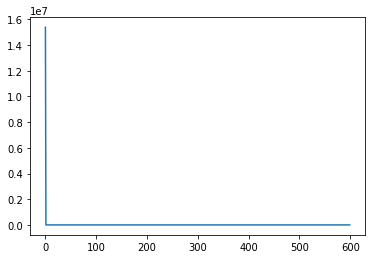

0.652
epoch 0: err 18797398.501099
epoch 1: err 2.130011
epoch 2: err 2.105157
epoch 3: err 2.086227
epoch 4: err 2.072791
epoch 5: err 2.065700
epoch 6: err 2.066040
epoch 7: err 2.074114
epoch 8: err 2.088767
epoch 9: err 2.107488
epoch 10: err 2.127195
epoch 11: err 2.145223
epoch 12: err 2.159940
epoch 13: err 2.170864
epoch 14: err 2.178395
epoch 15: err 2.183409
epoch 16: err 2.186861
epoch 17: err 2.189508
epoch 18: err 2.191774
epoch 19: err 2.193785
epoch 20: err 2.195499
epoch 21: err 2.196872
epoch 22: err 2.197968
epoch 23: err 2.199004
epoch 24: err 2.200315
epoch 25: err 2.202287
epoch 26: err 2.205286
epoch 27: err 2.209605
epoch 28: err 2.215437
epoch 29: err 2.222868
epoch 30: err 2.231890
epoch 31: err 2.242421
epoch 32: err 2.254317
epoch 33: err 2.267401
epoch 34: err 2.281469
epoch 35: err 2.296309
epoch 36: err 2.311709
epoch 37: err 2.327464
epoch 38: err 2.343380
epoch 39: err 2.359282
epoch 40: err 2.375009
epoch 41: err 2.390423
epoch 42: err 2.405403
epoch 43

epoch 347: err 2.283092
epoch 348: err 2.280185
epoch 349: err 2.277292
epoch 350: err 2.274415
epoch 351: err 2.271552
epoch 352: err 2.268705
epoch 353: err 2.265873
epoch 354: err 2.263057
epoch 355: err 2.260258
epoch 356: err 2.257475
epoch 357: err 2.254709
epoch 358: err 2.251959
epoch 359: err 2.249227
epoch 360: err 2.246512
epoch 361: err 2.243815
epoch 362: err 2.241136
epoch 363: err 2.238474
epoch 364: err 2.235831
epoch 365: err 2.233206
epoch 366: err 2.230599
epoch 367: err 2.228011
epoch 368: err 2.225442
epoch 369: err 2.222892
epoch 370: err 2.220360
epoch 371: err 2.217847
epoch 372: err 2.215354
epoch 373: err 2.212880
epoch 374: err 2.210425
epoch 375: err 2.207989
epoch 376: err 2.205573
epoch 377: err 2.203176
epoch 378: err 2.200799
epoch 379: err 2.198441
epoch 380: err 2.196103
epoch 381: err 2.193785
epoch 382: err 2.191486
epoch 383: err 2.189207
epoch 384: err 2.186947
epoch 385: err 2.184707
epoch 386: err 2.182487
epoch 387: err 2.180287
epoch 388: err 2

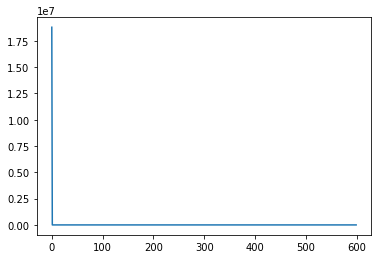

0.686
epoch 0: err 6395330.203694
epoch 1: err 2.195105
epoch 2: err 2.167662
epoch 3: err 2.147744
epoch 4: err 2.132242
epoch 5: err 2.119844
epoch 6: err 2.110326
epoch 7: err 2.104283
epoch 8: err 2.102910
epoch 9: err 2.107530
epoch 10: err 2.118739
epoch 11: err 2.135538
epoch 12: err 2.155192
epoch 13: err 2.174210
epoch 14: err 2.189711
epoch 15: err 2.200197
epoch 16: err 2.205514
epoch 17: err 2.206405
epoch 18: err 2.204036
epoch 19: err 2.199629
epoch 20: err 2.194220
epoch 21: err 2.188532
epoch 22: err 2.182972
epoch 23: err 2.177718
epoch 24: err 2.172861
epoch 25: err 2.168505
epoch 26: err 2.164818
epoch 27: err 2.162009
epoch 28: err 2.160295
epoch 29: err 2.159872
epoch 30: err 2.160905
epoch 31: err 2.163534
epoch 32: err 2.167879
epoch 33: err 2.174046
epoch 34: err 2.182116
epoch 35: err 2.192145
epoch 36: err 2.204151
epoch 37: err 2.218112
epoch 38: err 2.233965
epoch 39: err 2.251606
epoch 40: err 2.270899
epoch 41: err 2.291675
epoch 42: err 2.313749
epoch 43:

epoch 346: err 2.055611
epoch 347: err 2.051720
epoch 348: err 2.047841
epoch 349: err 2.043973
epoch 350: err 2.040116
epoch 351: err 2.036270
epoch 352: err 2.032436
epoch 353: err 2.028612
epoch 354: err 2.024798
epoch 355: err 2.020995
epoch 356: err 2.017202
epoch 357: err 2.013419
epoch 358: err 2.009646
epoch 359: err 2.005884
epoch 360: err 2.002131
epoch 361: err 1.998388
epoch 362: err 1.994656
epoch 363: err 1.990933
epoch 364: err 1.987221
epoch 365: err 1.983519
epoch 366: err 1.979827
epoch 367: err 1.976146
epoch 368: err 1.972475
epoch 369: err 1.968815
epoch 370: err 1.965166
epoch 371: err 1.961527
epoch 372: err 1.957900
epoch 373: err 1.954284
epoch 374: err 1.950679
epoch 375: err 1.947086
epoch 376: err 1.943505
epoch 377: err 1.939936
epoch 378: err 1.936379
epoch 379: err 1.932834
epoch 380: err 1.929302
epoch 381: err 1.925783
epoch 382: err 1.922277
epoch 383: err 1.918784
epoch 384: err 1.915304
epoch 385: err 1.911839
epoch 386: err 1.908387
epoch 387: err 1

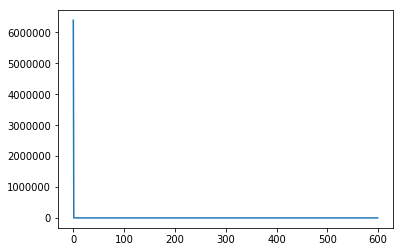

0.696
epoch 0: err 1362423104.946673
epoch 1: err 2.192166
epoch 2: err 2.183230
epoch 3: err 2.175008
epoch 4: err 2.167277
epoch 5: err 2.159979
epoch 6: err 2.153211
epoch 7: err 2.147223
epoch 8: err 2.142409
epoch 9: err 2.139252
epoch 10: err 2.138223
epoch 11: err 2.139629
epoch 12: err 2.143454
epoch 13: err 2.149266
epoch 14: err 2.156216
epoch 15: err 2.163157
epoch 16: err 2.168817
epoch 17: err 2.171999
epoch 18: err 2.171777
epoch 19: err 2.167669
epoch 20: err 2.159748
epoch 21: err 2.148654
epoch 22: err 2.135468
epoch 23: err 2.121521
epoch 24: err 2.108195
epoch 25: err 2.096752
epoch 26: err 2.088173
epoch 27: err 2.082991
epoch 28: err 2.081181
epoch 29: err 2.082189
epoch 30: err 2.085107
epoch 31: err 2.088922
epoch 32: err 2.092756
epoch 33: err 2.096009
epoch 34: err 2.098406
epoch 35: err 2.099957
epoch 36: err 2.100871
epoch 37: err 2.101468
epoch 38: err 2.102102
epoch 39: err 2.103115
epoch 40: err 2.104800
epoch 41: err 2.107392
epoch 42: err 2.111065
epoch 

epoch 346: err 0.908145
epoch 347: err 0.906850
epoch 348: err 0.905573
epoch 349: err 0.904311
epoch 350: err 0.903067
epoch 351: err 0.901838
epoch 352: err 0.900625
epoch 353: err 0.899429
epoch 354: err 0.898248
epoch 355: err 0.897082
epoch 356: err 0.895932
epoch 357: err 0.894796
epoch 358: err 0.893676
epoch 359: err 0.892570
epoch 360: err 0.891478
epoch 361: err 0.890400
epoch 362: err 0.889337
epoch 363: err 0.888287
epoch 364: err 0.887251
epoch 365: err 0.886229
epoch 366: err 0.885219
epoch 367: err 0.884222
epoch 368: err 0.883239
epoch 369: err 0.882267
epoch 370: err 0.881308
epoch 371: err 0.880362
epoch 372: err 0.879427
epoch 373: err 0.878504
epoch 374: err 0.877593
epoch 375: err 0.876693
epoch 376: err 0.875804
epoch 377: err 0.874927
epoch 378: err 0.874060
epoch 379: err 0.873204
epoch 380: err 0.872359
epoch 381: err 0.871524
epoch 382: err 0.870699
epoch 383: err 0.869885
epoch 384: err 0.869080
epoch 385: err 0.868285
epoch 386: err 0.867500
epoch 387: err 0

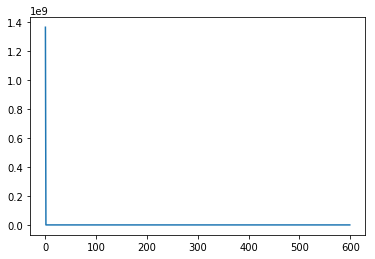

0.738
epoch 0: err 132705366.360730
epoch 1: err 2.247575
epoch 2: err 2.240308
epoch 3: err 2.234215
epoch 4: err 2.228918
epoch 5: err 2.224151
epoch 6: err 2.219722
epoch 7: err 2.215484
epoch 8: err 2.211319
epoch 9: err 2.207126
epoch 10: err 2.202820
epoch 11: err 2.198324
epoch 12: err 2.193568
epoch 13: err 2.188493
epoch 14: err 2.183055
epoch 15: err 2.177238
epoch 16: err 2.171070
epoch 17: err 2.164663
epoch 18: err 2.158247
epoch 19: err 2.152230
epoch 20: err 2.147228
epoch 21: err 2.144041
epoch 22: err 2.143524
epoch 23: err 2.146354
epoch 24: err 2.152746
epoch 25: err 2.162263
epoch 26: err 2.173774
epoch 27: err 2.185571
epoch 28: err 2.195639
epoch 29: err 2.202012
epoch 30: err 2.203169
epoch 31: err 2.198366
epoch 32: err 2.187800
epoch 33: err 2.172491
epoch 34: err 2.153803
epoch 35: err 2.132827
epoch 36: err 2.110379
epoch 37: err 2.087985
epoch 38: err 2.068623
epoch 39: err 2.055950
epoch 40: err 2.052861
epoch 41: err 2.060893
epoch 42: err 2.080519
epoch 4

epoch 346: err 0.670029
epoch 347: err 0.669688
epoch 348: err 0.669350
epoch 349: err 0.669016
epoch 350: err 0.668686
epoch 351: err 0.668359
epoch 352: err 0.668035
epoch 353: err 0.667715
epoch 354: err 0.667398
epoch 355: err 0.667085
epoch 356: err 0.666775
epoch 357: err 0.666469
epoch 358: err 0.666166
epoch 359: err 0.665866
epoch 360: err 0.665569
epoch 361: err 0.665275
epoch 362: err 0.664985
epoch 363: err 0.664698
epoch 364: err 0.664413
epoch 365: err 0.664132
epoch 366: err 0.663854
epoch 367: err 0.663579
epoch 368: err 0.663306
epoch 369: err 0.663037
epoch 370: err 0.662770
epoch 371: err 0.662506
epoch 372: err 0.662245
epoch 373: err 0.661987
epoch 374: err 0.661731
epoch 375: err 0.661477
epoch 376: err 0.661227
epoch 377: err 0.660978
epoch 378: err 0.660732
epoch 379: err 0.660489
epoch 380: err 0.660248
epoch 381: err 0.660009
epoch 382: err 0.659772
epoch 383: err 0.659538
epoch 384: err 0.659306
epoch 385: err 0.659076
epoch 386: err 0.658848
epoch 387: err 0

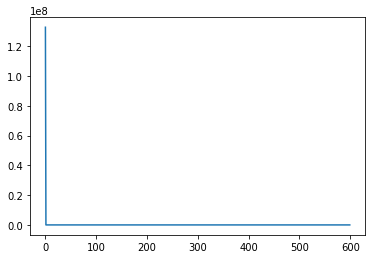

0.768
epoch 0: err 272482660.332858
epoch 1: err 2.222037
epoch 2: err 2.219722
epoch 3: err 2.217333
epoch 4: err 2.214849
epoch 5: err 2.212250
epoch 6: err 2.209516
epoch 7: err 2.206630
epoch 8: err 2.203575
epoch 9: err 2.200343
epoch 10: err 2.196928
epoch 11: err 2.193341
epoch 12: err 2.189611
epoch 13: err 2.185803
epoch 14: err 2.182035
epoch 15: err 2.178512
epoch 16: err 2.175571
epoch 17: err 2.173741
epoch 18: err 2.173795
epoch 19: err 2.176755
epoch 20: err 2.183752
epoch 21: err 2.195642
epoch 22: err 2.212397
epoch 23: err 2.232585
epoch 24: err 2.253528
epoch 25: err 2.272362
epoch 26: err 2.287298
epoch 27: err 2.297939
epoch 28: err 2.304652
epoch 29: err 2.307810
epoch 30: err 2.307441
epoch 31: err 2.303261
epoch 32: err 2.294959
epoch 33: err 2.282555
epoch 34: err 2.266756
epoch 35: err 2.249229
epoch 36: err 2.232718
epoch 37: err 2.220863
epoch 38: err 2.217434
epoch 39: err 2.224881
epoch 40: err 2.242802
epoch 41: err 2.267347
epoch 42: err 2.291942
epoch 4

epoch 346: err 0.613125
epoch 347: err 0.612885
epoch 348: err 0.612646
epoch 349: err 0.612407
epoch 350: err 0.612169
epoch 351: err 0.611931
epoch 352: err 0.611693
epoch 353: err 0.611456
epoch 354: err 0.611219
epoch 355: err 0.610983
epoch 356: err 0.610747
epoch 357: err 0.610512
epoch 358: err 0.610277
epoch 359: err 0.610043
epoch 360: err 0.609809
epoch 361: err 0.609575
epoch 362: err 0.609343
epoch 363: err 0.609111
epoch 364: err 0.608879
epoch 365: err 0.608648
epoch 366: err 0.608417
epoch 367: err 0.608188
epoch 368: err 0.607958
epoch 369: err 0.607730
epoch 370: err 0.607502
epoch 371: err 0.607274
epoch 372: err 0.607048
epoch 373: err 0.606822
epoch 374: err 0.606596
epoch 375: err 0.606371
epoch 376: err 0.606147
epoch 377: err 0.605924
epoch 378: err 0.605701
epoch 379: err 0.605480
epoch 380: err 0.605258
epoch 381: err 0.605038
epoch 382: err 0.604818
epoch 383: err 0.604599
epoch 384: err 0.604381
epoch 385: err 0.604164
epoch 386: err 0.603947
epoch 387: err 0

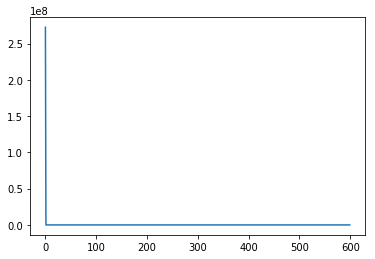

0.762
epoch 0: err 84362225.922959
epoch 1: err 2.250380
epoch 2: err 2.248171
epoch 3: err 2.246167
epoch 4: err 2.244323
epoch 5: err 2.242604
epoch 6: err 2.240982
epoch 7: err 2.239435
epoch 8: err 2.237945
epoch 9: err 2.236495
epoch 10: err 2.235073
epoch 11: err 2.233667
epoch 12: err 2.232268
epoch 13: err 2.230867
epoch 14: err 2.229456
epoch 15: err 2.228029
epoch 16: err 2.226580
epoch 17: err 2.225103
epoch 18: err 2.223595
epoch 19: err 2.222051
epoch 20: err 2.220469
epoch 21: err 2.218847
epoch 22: err 2.217186
epoch 23: err 2.215486
epoch 24: err 2.213751
epoch 25: err 2.211990
epoch 26: err 2.210213
epoch 27: err 2.208438
epoch 28: err 2.206694
epoch 29: err 2.205017
epoch 30: err 2.203465
epoch 31: err 2.202120
epoch 32: err 2.201098
epoch 33: err 2.200566
epoch 34: err 2.200767
epoch 35: err 2.202048
epoch 36: err 2.204909
epoch 37: err 2.210065
epoch 38: err 2.218527
epoch 39: err 2.231653
epoch 40: err 2.251107
epoch 41: err 2.278524
epoch 42: err 2.314808
epoch 43

epoch 346: err 0.503461
epoch 347: err 0.503446
epoch 348: err 0.503432
epoch 349: err 0.503417
epoch 350: err 0.503403
epoch 351: err 0.503388
epoch 352: err 0.503374
epoch 353: err 0.503360
epoch 354: err 0.503346
epoch 355: err 0.503332
epoch 356: err 0.503318
epoch 357: err 0.503304
epoch 358: err 0.503291
epoch 359: err 0.503277
epoch 360: err 0.503264
epoch 361: err 0.503251
epoch 362: err 0.503238
epoch 363: err 0.503224
epoch 364: err 0.503211
epoch 365: err 0.503199
epoch 366: err 0.503186
epoch 367: err 0.503173
epoch 368: err 0.503160
epoch 369: err 0.503148
epoch 370: err 0.503136
epoch 371: err 0.503123
epoch 372: err 0.503111
epoch 373: err 0.503099
epoch 374: err 0.503087
epoch 375: err 0.503075
epoch 376: err 0.503063
epoch 377: err 0.503051
epoch 378: err 0.503039
epoch 379: err 0.503028
epoch 380: err 0.503016
epoch 381: err 0.503004
epoch 382: err 0.502993
epoch 383: err 0.502982
epoch 384: err 0.502970
epoch 385: err 0.502959
epoch 386: err 0.502948
epoch 387: err 0

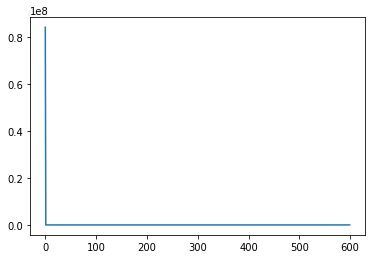

0.764


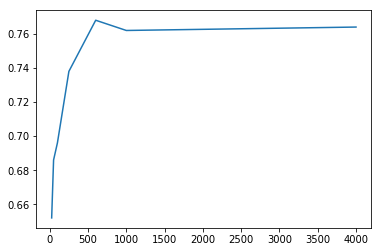

In [69]:
variablesToSelect = [25, 50, 100, 250, 600, 1000, 4000]
accuracy = []
b = []
best = 0
for i in variablesToSelect:
    topkdataset, topkdataset_test = selectTopK(i)
    w, wb, v, vb, err_curve = train(topkdataset, trainingLabels, 25, 0.01, 600)
    predictions = test(topkdataset_test.values,w, wb, v, vb)
    a = confusion_matrix(testingLabels,predictions)[1]
    accuracy.append(a)
    if a > best:
        best = a
        b = [i]
                
plt.plot(variablesToSelect,accuracy)
    

In [138]:
b

[25, 5, 0.02, 3800]